In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
from utilities.survey_response_utils import *
from utilities.classifier_utils import *
from utilities.constants import *
from utilities.params import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats
from itertools import chain

# Loading data

## Ad data

In [2]:
# Here, we will preprocess ad data, just like we had in the previous notebook.
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']
df_all = pd.concat(all_dataframes)
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [3]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [4]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
124152,M1 Limited,python,2017-01-01,2,22,0.090909
100834,IHIS - Integrated Health Information Systems P...,ssl/tls,2017-01-01,1,15,0.066667
100833,IHIS - Integrated Health Information Systems P...,sql,2017-01-01,1,15,0.066667
15900,Agilysys Singapore Pte Ltd,system integration,2017-01-01,1,2,0.500000
15899,Agilysys Singapore Pte Ltd,sql,2017-01-01,1,2,0.500000
15895,Agilysys Singapore Pte Ltd,pos system,2017-01-01,1,2,0.500000
15894,Agilysys Singapore Pte Ltd,multi-task,2017-01-01,1,2,0.500000
15893,Agilysys Singapore Pte Ltd,microsoft office suite,2017-01-01,1,2,0.500000
15892,Agilysys Singapore Pte Ltd,microsoft office (powerpoint),2017-01-01,1,2,0.500000
15891,Agilysys Singapore Pte Ltd,microsoft office (excel),2017-01-01,1,2,0.500000


In [5]:
len(skills_df.Skill.unique().tolist())

987

In [6]:
len(skills_df.Company.unique().tolist())

2264

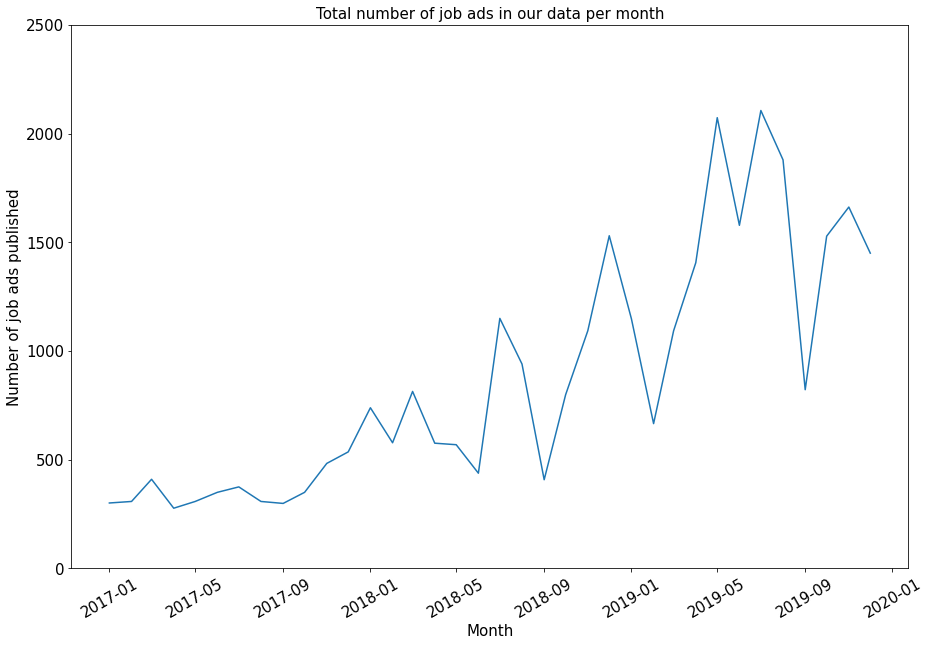

In [7]:
plt.figure(figsize=(15,10))
plt.plot(skills_df[['Company', 'Date', 'Total']].drop_duplicates().groupby('Date').sum())
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Number of job ads published', fontsize=15)
plt.ylim([0,2500])
plt.xlabel('Month', fontsize=15)
plt.title('Total number of job ads in our data per month', fontsize=15)
plt.show()

## Creating ground truth out of ad data

In [8]:
skills_df[['Company', 'Date', 'Total']].drop_duplicates().groupby('Date').sum().\
                reset_index()

,Date,Total
0,2017-01-01,301
1,2017-02-01,308
2,2017-03-01,410
3,2017-04-01,277
4,2017-05-01,308
5,2017-06-01,350
6,2017-07-01,375
7,2017-08-01,308
8,2017-09-01,299
9,2017-10-01,350


In [9]:
monthly_skill_data = skills_df[['Skill', 'Date', 'Job Postings Raw']].groupby(['Skill', 'Date']).sum().\
                reset_index().rename(columns={'Job Postings Raw': 'Count', 'Skill': 'TagName'})
monthly_skill_data['Date'] = monthly_skill_data['Date'].astype(str)
monthly_skill_data.head(10)

,TagName,Date,Count
0,.net,2017-01-01,19
1,.net,2017-02-01,16
2,.net,2017-03-01,34
3,.net,2017-04-01,24
4,.net,2017-05-01,26
5,.net,2017-06-01,23
6,.net,2017-07-01,23
7,.net,2017-08-01,20
8,.net,2017-09-01,25
9,.net,2017-10-01,19


In [49]:
log_monthly_skill_data = skills_df[['Skill', 'Company', 'Date', 'Job Postings Raw']].\
            assign(log_val=skills_df['Job Postings Raw'].apply(np.log))[['Skill', 'Date', 'log_val']].\
                groupby(['Skill', 'Date']).sum().\
                    reset_index().rename(columns={'log_val': 'Logpop', 'Skill': 'TagName'})
log_monthly_skill_data['Date'] = log_monthly_skill_data['Date'].astype(str)
log_monthly_skill_data.head(10)

,TagName,Date,Logpop
0,.net,2017-01-01,3.178054
1,.net,2017-02-01,1.945910
2,.net,2017-03-01,5.337538
3,.net,2017-04-01,4.852030
4,.net,2017-05-01,5.375278
5,.net,2017-06-01,3.688879
6,.net,2017-07-01,5.545177
7,.net,2017-08-01,4.025352
8,.net,2017-09-01,3.871201
9,.net,2017-10-01,4.248495


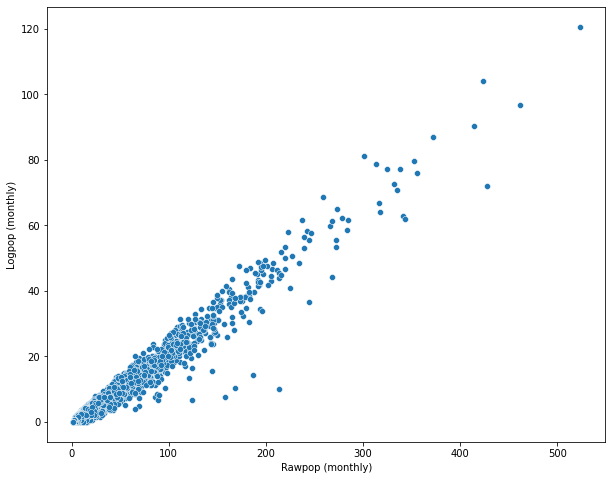

In [55]:
plt.subplots(1,1,figsize=(10,8))
sns.scatterplot(data=pd.merge(monthly_skill_data, log_monthly_skill_data, on=['TagName', 'Date']), 
                x='Count', y='Logpop')
plt.xlabel('Rawpop (monthly)')
plt.ylabel('Logpop (monthly)')
plt.show()

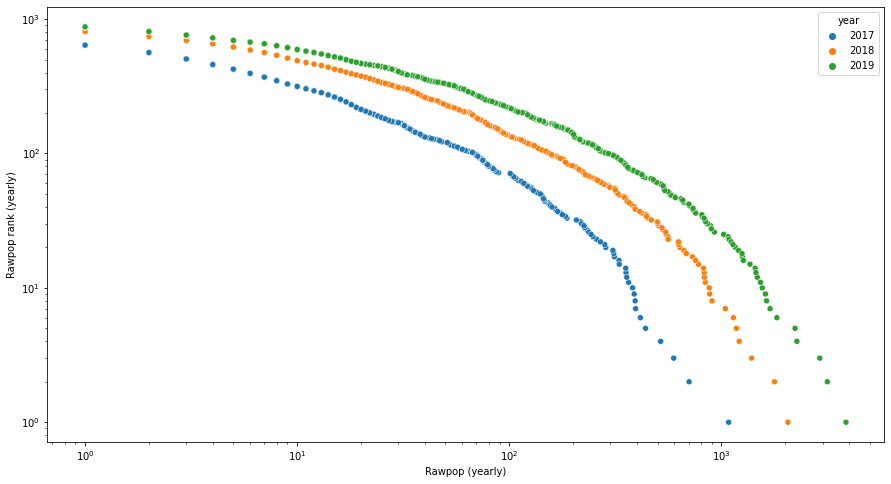

In [74]:
plt.subplots(1,1,figsize=(15,8))
aggregated_by_year_rawpop = \
        monthly_skill_data.assign(year=monthly_skill_data.Date.apply(lambda x: x.split('-')[0])).\
                                  groupby(['year', 'TagName']).sum().reset_index()
rawpop_ranked = aggregated_by_year_rawpop.assign(Ranking=
                    aggregated_by_year_rawpop[['year', 'TagName', 'Count']].\
                         groupby('year').rank(ascending=False).Count)
sns.scatterplot(data=rawpop_ranked, 
                x='Count', y='Ranking', hue='year')
plt.xlabel('Rawpop (yearly)')
plt.ylabel('Rawpop rank (yearly)')
plt.xscale('log')
plt.yscale('log')

In [69]:
rawpop_ranked

,year,TagName,Count,Ranking
0,2017,.net,285,20.0
1,2017,3d graphics,4,458.5
2,2017,3d modeling,12,292.5
3,2017,a/b testing,8,348.0
4,2017,account management,152,43.0
...,...,...,...,...
2440,2019,zbrush,7,655.0
2441,2019,zeplin,8,633.5
2442,2019,zeromq,1,875.0
2443,2019,zigbee,7,655.0


## Method I: Binary top-K ground truth

In [11]:
def get_top_k_per_period(tag_counts_monthly, k, n_periods=4):
    result = tag_counts_monthly.assign(year=tag_counts_monthly.Date.\
                        apply(lambda x: x.split('-')[0])).assign(period=tag_counts_monthly.Date.\
                        apply(lambda x: str((int(x.split('-')[1])-1) // (12//n_periods)))).\
                        groupby(['year', 'period', 'TagName']).sum().reset_index().\
                        sort_values(by=['year', 'period', 'Count'], 
                            ascending=[True, True, False])[['year', 'period', 'TagName', 'Count']]
    if k == -1:
        return result
    return result.groupby(['year', 'period']).head(k).reset_index().drop('index', axis=1)

def get_diffs_multiple_periods_per_year(tag_counts_monthly, k, n_periods=4):
    top_k_per_period = get_top_k_per_period(tag_counts_monthly, k, n_periods)
    
    top_k_per_period = top_k_per_period.assign(combined_key=top_k_per_period.\
                                                       apply(lambda x: x['year']+'-'+str(int(x['period'])+1), 
                                                             axis=1))
    keys = top_k_per_period.combined_key.unique()
    result_dict = {keys[i]:top_k_per_period.loc[top_k_per_period.combined_key == keys[i]].TagName.values.tolist() 
                   for i in range(len(keys))}
    diffs = {}
    for key in keys:
        current_year = int(key.split('-')[0])
        current_period = int(key.split('-')[1])
        prev_key = str(current_year-1)+'-'+str(current_period)
        if prev_key in keys:
            diffs[key] = set(result_dict[key]).difference(set(result_dict[prev_key]))
    years = sorted(list(set([key.split('-')[0] for key in keys])))
    final_diffs = {year: set().union(*[diffs[key] for key in keys if key in diffs and 
                                            key.split('-')[0] == year]) for year in years}
    # final_diffs = {year: Counter(chain.from_iterable([diffs[key] for key in keys if key in diffs and 
    #                                         key.split('-')[0] == year])) for year in years}
    final_diffs = {k:v for k,v in final_diffs.items() if len(v)>0}
#     final_diffs = {years[i]:final_diffs[years[i]].difference(set().
#                                                      union(*[final_diffs[years[j]] for j in range(1,i-1)]))
#                    for i in range(1,len(years))}
    return final_diffs

def merge_final_diffs(final_diff_list):
    final_diff = {k: set().union(*[final_diff_list[i][k] for i in range(len(final_diff_list))]) 
                  for k in final_diff_list[0].keys()}
    return final_diff

In [12]:
def get_diffs_growth_criteria(tag_counts_monthly, too_much=100, at_least=400, 
                              growth_method='percentile', growth_param=0.8, n_periods=4):
    per_period_popularities = tag_counts_monthly.assign(year=tag_counts_monthly.Date.\
                        apply(lambda x: x.split('-')[0])).assign(period=tag_counts_monthly.Date.\
                        apply(lambda x: str((int(x.split('-')[1])-1) // (12//n_periods)))).\
                        groupby(['year', 'period', 'TagName']).sum().reset_index().\
                        sort_values(by=['year', 'period', 'Count'], 
                            ascending=[True, True, False])[['year', 'period', 'TagName', 'Count']]
    
    emergence_contenders = per_period_popularities.groupby(['year', 'period']).head(at_least).\
                                    reset_index().drop('index', axis=1)
    too_popular = per_period_popularities.groupby(['year', 'period']).head(too_much).\
                                    reset_index().drop('index', axis=1)
    too_popular['year'] = too_popular['year'].apply(lambda x: str(int(x)+1))
    too_popular = too_popular.loc[too_popular.year.apply(lambda x: x in emergence_contenders.year.unique())]
    
    shifted_df = per_period_popularities.copy().assign(year=per_period_popularities.year.
                                                       apply(lambda x: str(int(x)+1)))
    joined_df = pd.merge(per_period_popularities, shifted_df, on=['year', 'period', 'TagName'], 
                         suffixes=('_new', '_old'), 
                             how='inner').fillna(0)
    joined_df['growth'] = (joined_df['Count_new'] - joined_df['Count_old']) / joined_df['Count_old']
    if growth_method == 'percentile':
        for year in joined_df.year.unique():
            print(year)
            print(joined_df.loc[joined_df.year == year].growth.quantile(growth_param))
        also_contenders = pd.concat([joined_df.loc[(joined_df.year == year) & 
                                       (joined_df.growth >= 
                                        joined_df.loc[joined_df.year == year].growth.quantile(growth_param))]
                                            for year in joined_df.year.unique()])
    else:
        also_contenders = pd.concat([joined_df.loc[(joined_df.year == year) & 
                                       (joined_df.growth >= growth_param)]
                                            for year in joined_df.year.unique()])
    final_results_df = pd.merge(emergence_contenders[['TagName', 'year', 'period']], 
                                also_contenders[['TagName', 'year', 'period']], 
                            how='inner', on=['TagName', 'year', 'period'])
    final_results_df = pd.merge(final_results_df, too_popular[['TagName', 'year', 'period', 'Count']], how='outer')
    final_results_df = final_results_df.loc[pd.isna(final_results_df.Count)].drop(columns=['Count'])
    result_dict = dict()
    for year in final_results_df.year.unique():
        result_dict[year] = set(final_results_df.loc[final_results_df.year == year].TagName.values)
    return result_dict, final_results_df
    
    
    

In [13]:
final_diffs = get_diffs_multiple_periods_per_year(monthly_skill_data, 350, 4)
# final_diffs, growths_df = get_diffs_growth_criteria(monthly_skill_data, 300, 400, 
#                                                            growth_method='percentile', growth_param=0.8) 

In [14]:
final_diffs

{'2018': {'3d modeling',
  'a/b testing',
  'adobe after effects',
  'adobe analytics',
  'adobe indesign',
  'adobe marketo',
  'adobe phonegap',
  'aix',
  'amazon dynamodb',
  'aml/cft',
  'android sdk',
  'animation',
  'anti-spam programming',
  'apache hbase',
  'apache hive',
  'apache impala',
  'apache kafka',
  'apache maven',
  'apache pig',
  'apache spark',
  'apache struts',
  'apache subversion (svn)',
  'apache tomcat',
  'apache web server',
  'apache zookeeper',
  'api integration',
  'api management system',
  'appdynamics',
  'application integration',
  'architecture',
  'augmented/virtual reality',
  'autocad',
  'autodesk',
  'automation testing',
  'autonomous vehicle',
  'aveva',
  'blockchain technology',
  'breeze',
  'business intelligence (bi) tools',
  'caffe',
  'centos',
  'ceph',
  'cisco webex',
  'cloud infrastructure management',
  'cloudera',
  'computer systems',
  'computer vision',
  'confluence',
  'containerization (web)',
  'content delivery n

In [15]:
fd_300 = get_diffs_multiple_periods_per_year(monthly_skill_data, 300, 4)
fd_350 = get_diffs_multiple_periods_per_year(monthly_skill_data, 350, 4)

In [16]:
fd_300['2018'].difference(fd_350['2018'])

{'benchmarking',
 'cad (computer aided design)',
 'data science',
 'data visualisation',
 'data/text mining',
 'digital media',
 'e-mail marketing',
 'ehs',
 'endpoint security',
 'extract, transform, load (etl)',
 'financial analysis',
 'fintech',
 'hadoop',
 'hibernate',
 'ifrs',
 'informatica',
 'it service management',
 'kanban',
 'microsoft project',
 'postgresql',
 'predictive modelling',
 'r-programming',
 'real time operating system (rtos)',
 'web design',
 'xsl'}

In [17]:
[len(v) for k,v in final_diffs.items()]

[225, 152]

In [18]:
len(set(final_diffs['2018']).intersection(set(final_diffs['2019'])))

69

## Method II: Continuous ground truth

In [19]:
def get_skill_af_icf_scores(full_skill_df, tag_counts_monthly, n_periods=4, with_icf=True, with_log=True):
    af_df = get_top_k_per_period(tag_counts_monthly, k=-1, n_periods=n_periods)
    base_icf_df = full_skill_df[['Company', 'Skill', 'Date']].assign(Count=1).\
                    assign(year=full_skill_df.Date.\
                        apply(lambda x: str(x).split('-')[0])).assign(period=full_skill_df.Date.\
                            apply(lambda x: str((int(str(x).split('-')[1])-1) // (12//n_periods)))).\
                                rename(columns={'Skill': 'TagName'})
    base_icf_df = base_icf_df.drop('Date', axis=1).drop_duplicates()
    total_company_counts = base_icf_df[['year', 'period', 'Company', 'Count']].drop_duplicates().\
                                groupby(['year', 'period']).sum().reset_index().rename(columns={'Count': 'Companies'})
    icf_df = base_icf_df[['TagName', 'year', 'period', 'Count']].\
                                groupby(['TagName', 'year', 'period']).sum().reset_index()
    joined_df = pd.merge(af_df, icf_df, on=['TagName', 'year', 'period'], suffixes=('_af', '_icf'))
    joined_df = pd.merge(joined_df, total_company_counts, on=['year', 'period'])
    if with_log:
        joined_df['af'] = joined_df['Count_af'].apply(np.log)
    else:
        joined_df['af'] = joined_df['Count_af']
    if with_icf:
        joined_df['icf'] = joined_df.apply(lambda x: np.log(x['Companies'] / (x['Count_icf'] + 1)), axis=1)
        joined_df['score'] = joined_df.apply(lambda x: x['af']*x['icf'], axis=1)
    else:
        joined_df['score'] = joined_df['af']
    return joined_df.sort_values(by=['year', 'period', 'score'], 
                            ascending=[True, True, False])
    

In [20]:
af_icf_scores = get_skill_af_icf_scores(skills_df, monthly_skill_data, n_periods=2, with_icf=False, with_log=False)

In [79]:
af_icf_per_year = af_icf_scores[['year', 'TagName', 'score']].groupby(['year', 'TagName']).sum().reset_index()
af_icf_per_year = pd.merge(af_icf_per_year, 
                   af_icf_per_year.assign(year=af_icf_per_year.year.apply(lambda x: str(int(x)+1))), 
                           on=['year', 'TagName'], suffixes=('_new', '_old'), how='outer')
af_icf_per_year = af_icf_per_year.loc[af_icf_per_year.year != af_icf_per_year.year.min()]
af_icf_per_year['score_old'] = af_icf_per_year['score_old'].apply(lambda x: x if not pd.isnull(x) else 0)
af_icf_per_year = af_icf_per_year.dropna(axis=0)
af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: x['score_new']-x['score_old'], axis=1)
# af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: 
#             x['score_diff']/(2+np.log(1+x['score_old'])), axis=1)
old_score_quantiles = {year: af_icf_per_year.loc[af_icf_per_year.year==year].score_old.quantile(0.8) for year in 
            af_icf_per_year.year.unique()}
print(old_score_quantiles)
diff_quantiles = {year: af_icf_per_year.loc[af_icf_per_year.year==year].score_diff.quantile(0.65) for year in 
            af_icf_per_year.year.unique()}
print(diff_quantiles)
af_icf_top_ranks = af_icf_per_year.loc[(af_icf_per_year.\
                          apply(lambda x: x['score_old'] <= old_score_quantiles[x['year']], axis=1)) & 
                                 (af_icf_per_year.\
                          apply(lambda x: x['score_diff'] >= diff_quantiles[x['year']], axis=1))].copy()
af_icf_top_ranks = af_icf_top_ranks.sort_values(['year', 'score_diff'], ascending=[True, False])
# af_icf_per_year = af_icf_per_year.sort_values(['year', 'score_diff'], 
#                                               ascending=[True, False]).groupby('year').head(150)

{'2018': 29.800000000000068, '2019': 70.0}
{'2018': 19.0, '2019': 23.0}


In [80]:
af_icf_top_ranks.score_old.min(), af_icf_top_ranks.score_diff.min()

(0.0, 19.0)

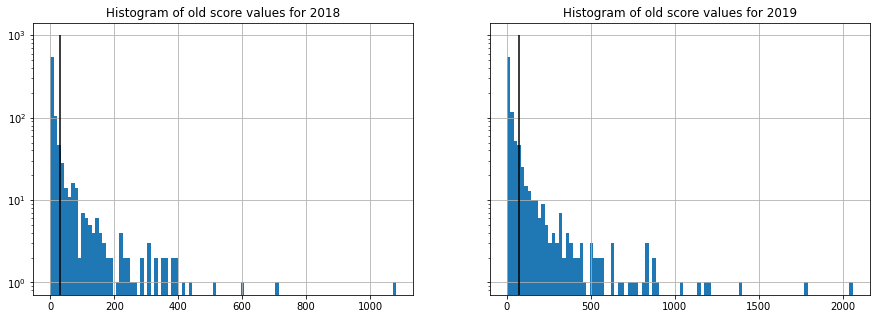

In [81]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True)
af_icf_per_year.score_old.loc[af_icf_per_year.year=='2018'].hist(bins=100, ax=ax1[0])
ax1[0].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2018'].score_old.
                  quantile(0.8), ymin=0, ymax=1000, color='black')

af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_old.hist(bins=100, ax=ax1[1])
ax1[1].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_old.
              quantile(0.8), ymin=0, ymax=1000, color='black')

plt.yscale('log')
ax1[0].set_title('Histogram of old score values for 2018')
ax1[1].set_title('Histogram of old score values for 2019')
plt.show()

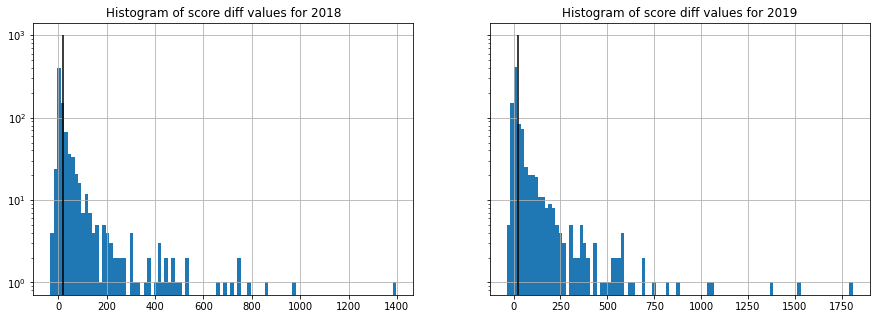

In [82]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True)
af_icf_per_year.score_diff.loc[af_icf_per_year.year=='2018'].hist(bins=100, ax=ax1[0])
ax1[0].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2018'].score_diff.
                  quantile(0.65), ymin=0, ymax=1000, color='black')

af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_diff.hist(bins=100, ax=ax1[1])
ax1[1].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_diff.
              quantile(0.65), ymin=0, ymax=1000, color='black')

plt.yscale('log')
ax1[0].set_title('Histogram of score diff values for 2018')
ax1[1].set_title('Histogram of score diff values for 2019')
plt.show()

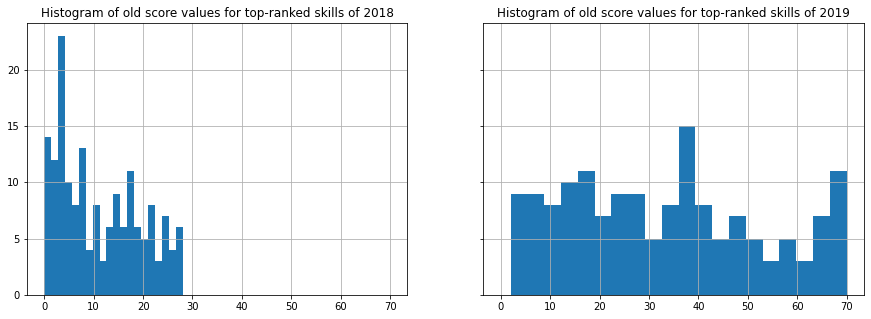

In [83]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True, sharex=True)
af_icf_top_ranks.score_old.loc[af_icf_top_ranks.year=='2018'].hist(bins=20, ax=ax1[0])

af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].score_old.hist(bins=20, ax=ax1[1])

ax1[0].set_title('Histogram of old score values for top-ranked skills of 2018')
ax1[1].set_title('Histogram of old score values for top-ranked skills of 2019')
plt.show()

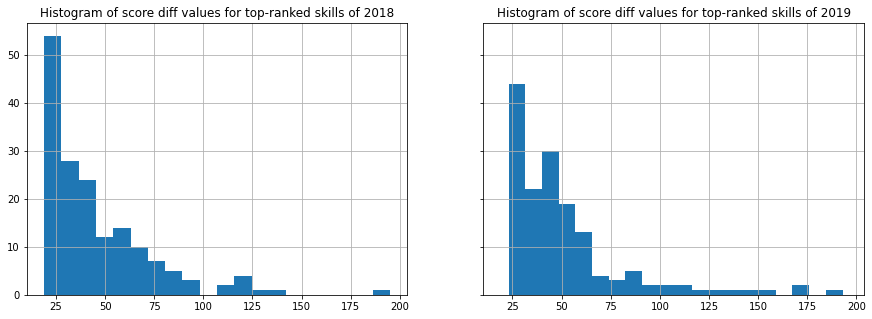

In [84]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True, sharex=True)
af_icf_top_ranks.score_diff.loc[af_icf_top_ranks.year=='2018'].hist(bins=20, ax=ax1[0])

af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].score_diff.hist(bins=20, ax=ax1[1])

ax1[0].set_title('Histogram of score diff values for top-ranked skills of 2018')
ax1[1].set_title('Histogram of score diff values for top-ranked skills of 2019')
plt.show()

In [85]:
af_icf_per_year.loc[af_icf_per_year.TagName=='pytorch']

,year,TagName,score_new,score_old,score_diff
1295,2018,pytorch,19.0,0.0,19.0
2191,2019,pytorch,40.0,19.0,21.0


In [86]:
af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].head(40)

,year,TagName,score_new,score_old,score_diff
2003,2019,kubernetes,245.0,52.0,193.0
2292,2019,social media (youtube),236.0,67.0,169.0
1948,2019,infrastructure-as-a-service (iaas),230.0,62.0,168.0
1893,2019,google ads,193.0,40.0,153.0
2169,2019,pl/sql,177.0,30.0,147.0
1620,2019,application security design,201.0,67.0,134.0
2285,2019,soap,197.0,66.0,131.0
2029,2019,managed security services (mss),140.0,23.0,117.0
2065,2019,microsoft office 365,171.0,57.0,114.0
2113,2019,network theorems,134.0,22.0,112.0


In [87]:
af_icf_top_ranks.loc[af_icf_top_ranks.TagName=='pytorch']

,year,TagName,score_new,score_old,score_diff
1295,2018,pytorch,19.0,0.0,19.0


In [88]:
second_final_diffs = {year: set(sorted(af_icf_top_ranks.loc[af_icf_top_ranks.year==year].TagName.values.tolist())) 
                   for year in af_icf_top_ranks.year.unique()}

In [89]:
len(second_final_diffs['2018']), len(second_final_diffs['2019'])

(166, 154)

In [90]:
second_final_diffs

{'2018': {'adobe creative suite',
  'adobe indesign',
  'adobe marketo',
  'aml/cft',
  'ansible',
  'apache hbase',
  'apache hive',
  'apache kafka',
  'apache maven',
  'apache subversion (svn)',
  'apache tomcat',
  'api management system',
  'application integration',
  'autocad',
  'automation testing',
  'autonomous vehicle',
  'aveva',
  'benchmarking',
  'bgp (border gateway protocol)',
  'blockchain technology',
  'business intelligence (bi) tools',
  'cad (computer aided design)',
  'caffe',
  'cisco webex',
  'computer systems',
  'computer vision',
  'confluence',
  'content delivery network (cdn)',
  'cryptocurrency',
  'cyber threat management',
  'd3.js',
  'data loss prevention',
  'data migration',
  'data quality control',
  'data science',
  'data structure',
  'data visualisation',
  'data wrangling',
  'data/text mining',
  'ddos',
  'deep learning',
  'devops',
  'digital media',
  'django',
  'doe troubleshooting',
  'e-mail marketing',
  'ecmascript',
  'ehs',


In [91]:
second_final_diffs['2019'].difference(final_diffs['2019'])

{'adobe indesign',
 'adobe marketo',
 'ajax',
 'animation',
 'apache subversion (svn)',
 'apache tomcat',
 'application integration',
 'application security design',
 'autocad',
 'blockchain technology',
 'computer systems',
 'computer vision',
 'confluence',
 'data wrangling',
 'database optimisation',
 'dynamic host configuration protocol',
 'elasticsearch',
 'enterprise web architecture',
 'financial analysis',
 'github',
 'google analytics',
 'google go programming language',
 'gui programming',
 'infrastructure-as-a-service (iaas)',
 'internet information services',
 'it service management',
 'junit',
 'kubernetes',
 'microsoft office 365',
 'microsoft project',
 'microsoft visual studio',
 'mvc framework',
 'natural language processing (nlp)',
 'network systems',
 'openshift',
 'oracle weblogic',
 'parallel programming',
 'penetration testing',
 'powershell',
 'proxy',
 'react native',
 'redis',
 'sap businessobjects',
 'sas',
 'scala',
 'sdk',
 'selenium',
 'siem platforms',
 's

In [92]:
second_final_diffs['2018'].difference(final_diffs['2018'])

{'adobe creative suite',
 'ansible',
 'benchmarking',
 'bgp (border gateway protocol)',
 'cad (computer aided design)',
 'data science',
 'data structure',
 'data visualisation',
 'data wrangling',
 'data/text mining',
 'deep learning',
 'devops',
 'digital media',
 'e-mail marketing',
 'ehs',
 'enterprise systems',
 'extract, transform, load (etl)',
 'financial analysis',
 'fintech',
 'hadoop',
 'hibernate',
 'ifrs',
 'informatica',
 'it service management',
 'jsp (javaserver pages)',
 'microsoft project',
 'mongodb',
 'mpls',
 'ospf',
 'parallel programming',
 'postgresql',
 'predictive modelling',
 'process optimisation',
 'publishing',
 'r-programming',
 'restful api',
 'search-engine marketing',
 'shell scripts',
 'software quality',
 'source code',
 'statistical analysis',
 'web server'}

In [93]:
final_diffs['2019'].difference(second_final_diffs['2019'])

{'a/b testing',
 'adobe after effects',
 'adobe creative suite',
 'amazon dynamodb',
 'android sdk',
 'apache cordova',
 'apache hbase',
 'apache spark',
 'appdynamics',
 'application maintenance',
 'bioinformatics',
 'caffe',
 'chatbot',
 'cognos',
 'containerization (web)',
 'control-m',
 'data loss prevention',
 'data recovery',
 'digital platforms',
 'dynamic analysis',
 'e-payment',
 'ehs',
 'end-user computing',
 'endpoint security',
 'enterprise javabeans',
 'esb (enterprise service bus)',
 'field-programmable gate array (integrated circuit)',
 'geneos',
 'gradle',
 'hadoop distributed file system',
 'hardware development',
 'hris',
 'ifrs',
 'it administration',
 'java persistence api (jpa)',
 'microsoft ssis',
 'nas infrastructure',
 'nginx',
 'opencv',
 'plc programming',
 'predictive modelling',
 'pytorch',
 'quickbooks',
 'rabbitmq',
 'simple network management protocol (snmp)',
 'spss',
 'stata',
 'statistical process control',
 'typescript',
 'ubuntu',
 'user experience e

In [94]:
final_diffs['2018'].difference(second_final_diffs['2018'])

{'3d modeling',
 'a/b testing',
 'adobe after effects',
 'adobe analytics',
 'adobe phonegap',
 'aix',
 'amazon dynamodb',
 'android sdk',
 'animation',
 'anti-spam programming',
 'apache impala',
 'apache pig',
 'apache spark',
 'apache struts',
 'apache web server',
 'apache zookeeper',
 'api integration',
 'appdynamics',
 'architecture',
 'augmented/virtual reality',
 'autodesk',
 'breeze',
 'centos',
 'ceph',
 'cloud infrastructure management',
 'cloudera',
 'containerization (web)',
 'csp (content security policy)',
 'data cleaning',
 'data communications',
 'data security',
 'digital platforms',
 'domain driven design',
 'elk stack',
 'embedded application development',
 'enterprise application integration (eai)',
 'enterprise javabeans',
 'field-programmable gate array (integrated circuit)',
 'firebase',
 'gamification',
 'geographic information system (gis)',
 'github',
 'global system for mobiles',
 'gnu compiler collection',
 'gradle',
 'hlr database',
 'hootsuite',
 'http/ht

In [95]:
len(second_final_diffs['2018'].intersection(second_final_diffs['2019']))

68

### Computing the best baseline classifier

In [96]:
def compute_best_baseline(final_diff_dict, mode='topk'):
    max_f1 = 0
    bestprec = 0
    bestrec = 0
    if mode == 'topk':
        besti = 350
    else:
        besti = 50
    initial_i = besti + 1
    for i in range(initial_i, initial_i+500, 10):
        if mode == 'topk':
            df1 = get_top_k_per_period(monthly_skill_data, i, 4)
            df1 = df1.loc[df1.year == '2017']
            df2 = get_top_k_per_period(monthly_skill_data, initial_i-1, 4)
            df2 = df2.loc[df2.year == '2017']

            another_baseline_set = set().union(*[set(df1.loc[df1.period==str(j)].TagName.values.tolist()).\
                                    difference(df2.loc[df2.period==str(j)].TagName.values.tolist()) 
                                                 for j in range(4)])
        else:
            another_baseline_set = set(af_icf_per_year.loc[(af_icf_per_year.year=='2018') &
                                      (af_icf_per_year.score_old < old_score_quantiles['2018'])].\
                                        sort_values('score_old', ascending=False).head(i).TagName.values.tolist())
        
        curr_tot = len(another_baseline_set)
        curr_tp = len(another_baseline_set.intersection(final_diff_dict['2018']))
        curr_ap = len(set(final_diff_dict['2018']))
        if curr_ap == 0 or curr_tot == 0:
            continue
        curr_prec = curr_tp / curr_tot
        curr_rec = curr_tp / curr_ap
        if curr_prec == 0 or curr_rec == 0:
            continue
        curr_f1 = 2*curr_prec*curr_rec / (curr_prec+curr_rec)
        print(i, curr_tot, curr_tp)
        if curr_f1 > max_f1:
            max_f1 = curr_f1
            bestprec = curr_prec
            bestrec = curr_rec
            besti = i
            
    return besti, max_f1, bestprec, bestrec

besti, max_f1, bestprec, bestrec = compute_best_baseline(second_final_diffs, mode='tfidf')
print(besti, max_f1, bestprec, bestrec)

51 51 36
61 61 42
71 71 48
81 81 54
91 91 57
101 101 62
111 111 67
121 121 72
131 131 75
141 141 77
151 151 81
161 161 84
171 171 88
181 181 90
191 191 93
201 201 97
211 211 100
221 221 102
231 231 104
241 241 108
251 251 111
261 261 115
271 271 118
281 281 122
291 291 123
301 301 126
311 311 130
321 321 132
331 331 134
341 341 137
351 351 139
361 361 142
371 371 144
381 381 144
391 391 147
401 401 150
411 411 153
421 421 155
431 431 155
441 441 155
451 451 155
461 461 157
471 471 158
481 481 159
491 491 159
501 501 159
511 511 160
521 521 160
531 531 160
541 541 161
281 0.5458612975391499 0.43416370106761565 0.7349397590361446


In [97]:
def get_common_keys_to_keep_topk(monthly_skill_data, larger_k, smaller_k, n_periods=4):
    years = monthly_skill_data.Date.apply(lambda x: x.split('-')[0]).unique()
    results = list()
    results_dict = dict()
    for year in years:
        df_candidate = get_top_k_per_period(monthly_skill_data, larger_k, n_periods)
        df_candidate = df_candidate.loc[df_candidate.year == year]
        df_already_emerged = get_top_k_per_period(monthly_skill_data, smaller_k, n_periods)
        df_already_emerged = df_already_emerged.loc[df_already_emerged.year == year]
        skill_set = set().union(*[set(df_candidate.loc[df_candidate.period==str(i)].TagName.values).\
                        difference(df_already_emerged.loc[df_already_emerged.period==str(i)].TagName.values) 
                                  for i in range(n_periods)])
        results_dict[year] = skill_set
        skill_set = [skill_name+'_'+year+'-'+str(int(year)+1) for skill_name in skill_set]
        results.extend(skill_set)
    return results, results_dict[max(years)]

def get_common_keys_to_keep_tfidf(monthly_skill_data, tfidf_data, quantile, k):
    years = monthly_skill_data.Date.apply(lambda x: x.split('-')[0]).unique()
    results = list()
    results_dict = dict()
    for year in years:
        if year == min(years):
            continue
        skill_set = set(tfidf_data.loc[(tfidf_data.year==year)&
                       (tfidf_data.score_old < tfidf_data.loc[tfidf_data.year==year].score_old.quantile(quantile))].\
                            sort_values('score_old', ascending=False).head(k).TagName.values.tolist())
        results_dict[year] = skill_set
        skill_set = [skill_name+'_'+str(int(year)-1)+'-'+year for skill_name in skill_set]
        results.extend(skill_set)
    return results, results_dict[max(years)]

def get_definitely_not_emerging(monthly_skill_data, k, n_periods=4):
    years = monthly_skill_data.Date.apply(lambda x: x.split('-')[0]).unique()
    top_k = get_top_k_per_period(monthly_skill_data, k, n_periods)
    top_k['repetition_count'] = 1
    top_k = top_k[['year', 'TagName', 'repetition_count']].groupby(['year', 'TagName']).sum().reset_index()
    top_k_not_emerging = top_k.loc[top_k.repetition_count == n_periods]
    results = dict()
    for year in years:
        results[year] = top_k_not_emerging.loc[top_k_not_emerging.year == str(int(year)-1)].TagName.values
    return results

In [190]:
# common_keys_to_keep, skills_to_keep_eval = get_common_keys_to_keep_topk(monthly_skill_data, 461, 350, 4)
# definitely_not_emerging = get_definitely_not_emerging(monthly_skill_data, 350, n_periods=4)
common_keys_to_keep, skills_to_keep_eval = get_common_keys_to_keep_tfidf(
                                monthly_skill_data, af_icf_per_year, 0.8, 321)

In [191]:
common_keys_to_keep

['oracle 10g, 11g, 12c_2017-2018',
 'postgresql_2017-2018',
 'server administration_2017-2018',
 'crystal reports_2017-2018',
 'cyber threat management_2017-2018',
 'apache hbase_2017-2018',
 'biostatistics_2017-2018',
 'redux_2017-2018',
 'joomla_2017-2018',
 'xero_2017-2018',
 'cryptocurrency_2017-2018',
 'mobile technology_2017-2018',
 'end-user computing_2017-2018',
 'arduino_2017-2018',
 'microsoft project_2017-2018',
 'sap hana_2017-2018',
 'data center infrastructure management_2017-2018',
 'statistical analysis_2017-2018',
 'codeigniter_2017-2018',
 'web application firewall (waf)_2017-2018',
 'web server_2017-2018',
 'quickbooks_2017-2018',
 'devops_2017-2018',
 'enterprise systems_2017-2018',
 'mobile device management system_2017-2018',
 'openshift_2017-2018',
 'autocad_2017-2018',
 'ospf_2017-2018',
 'robot operating system_2017-2018',
 'data/text mining_2017-2018',
 'cloudera_2017-2018',
 'apache web server_2017-2018',
 'vsphere_2017-2018',
 '3d modeling_2017-2018',
 'outs

In [101]:
def dict_to_ground_truth(gt_dict, time_periods, all_skills, shift_by_one_year=False, union_of_two_years=False):
    # Create the df for each of these periods (2018 skills also apply to 2017-2019 and 2017-2020, etc.)
#     if shift_by_one_year:
#         gt_dict = {str(int(k)+1): [y.replace('-', ' ') for y in gt_dict[k]] for k in gt_dict}
#     elif union_of_two_years:
#         gt_dict = {k: [y.replace('-', ' ') for y in set(chain.from_iterable(
#                     [gt_dict[k], gt_dict.get(str(int(k)-1), [])]))] for k in gt_dict}
#     else:
#         gt_dict = {k: [y.replace('-', ' ') for y in gt_dict[k]] for k in gt_dict}
    dict_for_df = {time_period_key: set(chain.from_iterable(
                    [gt_dict[k] for k in gt_dict if int(k) > int(time_period_key.split('-')[0])
                                                and int(k) <= int(time_period_key.split('-')[1])
                    ])) for time_period_key in time_periods}
    skill_gt_df = all_skills[['TagName']].assign(Skills=all_skills.TagName.apply(lambda x: x.replace('-', ' ')))\
                        .copy().drop_duplicates().reset_index().drop(['index', 'TagName'], axis=1)
    for time_period_key in time_periods:
        skill_gt_df[time_period_key] = skill_gt_df.Skills.apply(lambda x: x in dict_for_df[time_period_key])
    return skill_gt_df

In [102]:
tp = {
    '2017-2018': (np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
    '2018-2019': (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')),
#     '2019-2020': (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#     '2018-2020': (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#     '2017-2019': (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
#     '2017-2020': (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))
}
# final_result_df = dict_to_ground_truth({'2019':final_diffs['2019']}, tp, monthly_skill_data, shift_by_one_year=False, 
#                                       union_of_two_years=False)


# final_result_df = dict_to_ground_truth(final_diffs, tp, monthly_skill_data, shift_by_one_year=False, 
#                                       union_of_two_years=False)

final_result_df = dict_to_ground_truth(second_final_diffs, tp, monthly_skill_data, shift_by_one_year=False, 
                                      union_of_two_years=False)
final_result_df

,Skills,2017-2018,2018-2019
0,.net,False,False
1,3d graphics,False,False
2,3d modeling,False,False
3,a/b testing,False,False
4,ab initio,False,False
...,...,...,...
982,zeplin,False,False
983,zeppelin,False,False
984,zeromq,False,False
985,zigbee,False,False


## Survey data

In [2311]:
survey_data_filename = \
    '/Users/ramtinyazdanian/Downloads/Emerging skills and trend-anticipating firms - SGE_October 16, 2020_03.57.csv'
survey_data = pd.read_csv(survey_data_filename)
survey_in_rows = get_responses_in_rows([survey_data.loc[~pd.isnull(survey_data['UserLanguage'])]], 
                                       filter_nonsense=True, keep_unfinished=False)

In [6894]:
print(survey_data.loc[survey_data['Finished'] == 'TRUE'].shape)

(26, 650)


Now let's see a histogram of the skills' number of non-Unsure responses. The ones with less than 3 non-Unsures should probably be filtered out, but let's keep them for now.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2780bd30>]],
      dtype=object)

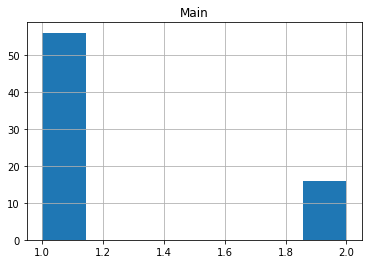

In [6895]:
survey_in_rows[['Skills', 'Main']].loc[survey_in_rows['Main'] != UNSURE]\
    .groupby('Skills').count().sort_values('Main').hist(bins=7)

In [6896]:
skills_to_keep = survey_in_rows[['Skills', 'Main']].loc[survey_in_rows['Main'] != UNSURE]\
    .groupby('Skills').count().reset_index()
skills_to_keep = skills_to_keep.loc[skills_to_keep['Main'] > 0].Skills.values
survey_in_rows = survey_in_rows.loc[survey_in_rows.Skills.apply(lambda x: x in skills_to_keep)]

## Auxiliary firm data

# Computing survey ground truth

The time period settings (and other settings) should be set through utilities/constants.py.

In [5839]:
# Use assemble_question_responses (or get_responses_in_rows) followed by find_majority_response_ground_truth 
# on the skills.
majorities, ground_truth_for_periods = find_majority_response_ground_truth(survey_in_rows)
y_reformatted = reformat_y(majorities, time_periods=tp)

Let's see some of the ground truth emerging skills for 2017-2020.

In [5840]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(majorities)

,Skills,Main,YesCol,NoCol,majority,modified_yescol,2017-2018,2018-2019,2019-2020,2018-2020,2017-2019,2017-2020
0,a/b testing,"[Unsure, Yes, Unsure]","[nan, Since 2017, nan]","[nan, nan, nan]",1,[2017-2020],True,False,False,False,True,True
1,adobe illustrator,"[Unsure, No, No]","[nan, nan, nan]","[nan, Skill has been important for too long, S...",0,[],False,False,False,False,False,False
2,ajax,"[No, Unsure, No]","[nan, nan, nan]","[nan, nan, Skill has been important for too long]",0,[],False,False,False,False,False,False
3,amazon redshift,"[Unsure, Yes, Unsure, Unsure, Unsure]","[nan, Since 2019, nan, nan, nan]","[nan, nan, nan, nan, nan]",1,[2019-2020],False,False,True,True,False,True
4,android studio,"[Yes, Yes, No]","[Since 2017, Earlier than 2017, nan]","[nan, nan, Skill has been important for too long]",1,[2017-2020],True,False,False,False,True,True
5,animation,"[No, Yes]","[nan, Earlier than 2017]","[Skill has been important for too long, nan]",0,[],False,False,False,False,False,False
6,ansible,"[Unsure, Yes, Unsure, Unsure]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",1,[],False,False,False,False,False,False
7,apache hive,"[Unsure, Unsure, Yes]","[nan, nan, Earlier than 2017]","[nan, nan, nan]",1,[],False,False,False,False,False,False
8,apache kafka,"[Yes, Yes, Unsure, Unsure, Unsure]","[Since 2017, Since 2017, nan, nan, nan]","[nan, nan, nan, nan, nan]",1,"[2017-2020, 2017-2020]",True,False,False,False,True,True
9,apache maven,"[No, Unsure, No, Yes, Unsure, Unsure, Unsure, ...","[nan, nan, nan, Earlier than 2017, nan, nan, n...","[Skill is not important enough, nan, Skill is ...",0,[],False,False,False,False,False,False


In [5841]:
len(ground_truth_for_periods['2017-2020']), majorities.shape[0]

(41, 112)

In [5842]:
ground_truth_for_periods['2017-2020']

['a/b testing',
 'amazon redshift',
 'android studio',
 'apache kafka',
 'augmented/virtual reality',
 'automation testing',
 'biostatistics',
 'blockchain technology',
 'computer vision',
 'cyber threat management',
 'data migration',
 'data quality control',
 'data science',
 'data security',
 'data visualisation',
 'docker',
 'elasticsearch',
 'encryption/cryptography',
 'fintech',
 'ggplot',
 'google analytics',
 'google go programming language',
 'graphql',
 'hadoop',
 'keras',
 'knowledge management',
 'market analysis',
 'micro-services',
 'mongodb',
 'nltk',
 'oauth 2.0',
 'plc programming',
 'quantitative analysis',
 'react.js',
 'search engine optimization (seo)',
 'sketch',
 'social media (youtube)',
 'spring framework',
 'tableau',
 'tensorflow',
 'vue.js']

### Looking at inter-rater agreement for the skills

We use Krippendorf's alpha.

In [6897]:
# simply use get_interrater_agreement from survey_response_utils
get_interrater_agreement(survey_in_rows, remove_unsure=True)

0.26190476190476186

Okay this inter-rater agreement is just terrible. It shows that people don't seem to agree, and the results of the survey may not be particularly useful.

## Global preprocessing

In [103]:
# Run reformat_y on the y ground truth dataframe.
# the two following lines are for ground truth that comes from 
# outside of the job ad dataset (which includes the survey)
# majorities = pickle.load(open('./stackoverflow_majorities.pkl', 'rb'))
# majorities = majorities.loc[majorities.Skills.apply(lambda x: x in set(skills_df.Skill.unique().tolist()))]
majorities = final_result_df
tp = {
    '2017-2018': (np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
    '2018-2019': (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')),
#     '2019-2020': (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#     '2018-2020': (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#     '2017-2019': (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
#     '2017-2020': (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))
}
y_reformatted = reformat_y(majorities, time_periods=tp)

In [104]:
majorities.shape

(987, 3)

In [105]:
all_emerging_list_for_inspection = \
    majorities.loc[majorities.apply(lambda x: any([x[y] == True for y in majorities.columns if y != 'Skills']), 
                                axis=1)].sort_values('Skills').Skills.values
all_emerging_list_for_inspection = [' '.join([capitalise_initials(y) for y in x.split()]) 
                                    for x in all_emerging_list_for_inspection]
print(', '.join(all_emerging_list_for_inspection))

Adobe Creative Suite, Adobe Indesign, Adobe Marketo, Adobe Premiere Pro, Ajax, Amazon Redshift, Aml/cft, Animation, Ansible, Apache Hbase, Apache Hive, Apache Kafka, Apache Maven, Apache Struts, Apache Subversion (svn), Apache Tomcat, Api Management System, Application Integration, Application Security Design, As400 System, Asp, Augmented/virtual Reality, Autocad, Automation Solution, Automation Testing, Autonomous Vehicle, Aveva, Benchmarking, Bgp (border Gateway Protocol), Bigquery, Biometrics, Biotechnology, Bitbucket, Blockchain Technology, Bluecoat, Building Management System, Business Intelligence (bi) Tools, Business Process Mapping, Cad (computer Aided Design), Caffe, Cgmp, Cisco Asa, Cisco Webex, Cobol, Computer Systems, Computer Vision, Confluence, Content Delivery Network (cdn), Cryptocurrency, Cyber Security Compliance, Cyber Threat Management, D3.js, Data Loss Prevention, Data Migration, Data Quality Control, Data Science, Data Security, Data Structure, Data Visualisation,

In [106]:
len(all_emerging_list_for_inspection)

243

In [107]:
all_non_emerging_list_for_inspection = \
    majorities.loc[majorities.apply(lambda x: all([x[y] == False for y in majorities.columns if y != 'Skills']), 
                                axis=1)].sort_values('Skills').Skills.values
all_non_emerging_list_for_inspection = [' '.join([capitalise_initials(y) for y in x.split()]) 
                                    for x in all_non_emerging_list_for_inspection]
print(', '.join(all_non_emerging_list_for_inspection))

.net, 3d Graphics, 3d Modeling, A/b Testing, Ab Initio, Account Management, Accounting Information Systems, Aconex, Active Directory, Active Directory Federation Services (adfs), Adas (architecture Design And Assessment System), Admission & Ticket Management, Ado.net, Adobe Acrobat Pro, Adobe After Effects, Adobe Analytics, Adobe Campaign, Adobe Cq5, Adobe Dreamweaver, Adobe Experience Manager, Adobe Flash, Adobe Illustrator, Adobe Lightroom, Adobe Phonegap, Adobe Photoshop, Adobe Xd, Aecosim, Ahrefs (seo), Airflow, Aix, Algorithm Design, Altera Quartus, Amazon Dynamodb, Amazon Web Services, Amortization, Ampl, Amqp, Anaconda, Analytical Design, Android, Android Sdk, Android Studio, Angularjs, Annuity, Anova, Ansys, Anti Spam Programming, Anti Virus Programming, Antlabs, Apache Ant, Apache Camel, Apache Cassandra, Apache Cordova, Apache Flume, Apache Ibatis, Apache Impala, Apache Jmeter, Apache Lucene, Apache Mxnet, Apache Oozie, Apache Pig, Apache Solr, Apache Spark, Apache Sqoop, Apa

In [108]:
majorities.loc[majorities.Skills.apply(lambda x: 'apache' in x)]

,Skills,2017-2018,2018-2019
58,apache ant,False,False
59,apache camel,False,False
60,apache cassandra,False,False
61,apache cordova,False,False
62,apache flume,False,False
63,apache hbase,True,False
64,apache hive,True,False
65,apache ibatis,False,False
66,apache impala,False,False
67,apache jmeter,False,False


In [109]:
y_reformatted

{'2017-2018':           Skills  row_class
 0           .net          0
 1    3d graphics          0
 2    3d modeling          0
 3    a/b testing          0
 4      ab initio          0
 ..           ...        ...
 982       zeplin          0
 983     zeppelin          0
 984       zeromq          0
 985       zigbee          0
 986         zuul          0
 
 [987 rows x 2 columns],
 '2018-2019':           Skills  row_class
 0           .net          0
 1    3d graphics          0
 2    3d modeling          0
 3    a/b testing          0
 4      ab initio          0
 ..           ...        ...
 982       zeplin          0
 983     zeppelin          0
 984       zeromq          0
 985       zigbee          0
 986         zuul          0
 
 [987 rows x 2 columns]}

## Rawpop

### Preprocessing

In [2319]:
# Run compute_total_poptype_mean with pop_type='raw' (for the normalisation) on original ad df
# Run compile_all_feature_dfs with pop_type='raw' on skills ad df (provide list of extraction methods 
# to feature_types)

# Run skills_to_indices to generate indices.
# Run create_train_test_split to create the training and test sets.
# Run generate_cv_folds on the training data to get... cv folds.

### Computation (training and validation)

In [2320]:
# Run cross_validate_with_quantile with the appropriate feature column name (e.g. 'linreg', 'tsfresh'). 
# Set C_LIST and QUANTILES through utilities/params.py

### Evaluation (test and manual investigation)

In [2321]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period

## Logpop

### Preprocessing

In [2322]:
# feature_type_to_use = 'linreg_nointercept'
# params_to_use = {feature_type_to_use:{'degree':2}}

params_to_use = {'tsfresh':{}, 'linreg_nointercept':{'degree': 2}, 'orig': {}}

In [2323]:
# # Run compute_total_poptype_mean with pop_type='log' (for the normalisation) on original ad df

# # To get quarterly data (or data grouped together in any other divisor of 12), run this
# # log_mean = compute_total_poptype_mean(group_time_steps_together(skills_df, 3, True), pop_type='log')

# # To get monthly data, run this
# log_mean = compute_total_poptype_mean(skills_df, pop_type='raw', based_on='skill')

# # Run compile_all_feature_dfs with pop_type='log' on skills ad df

# # To get quarterly data (or data grouped together in any other divisor of 12), run this
# # log_features_df = compile_all_feature_dfs(group_time_steps_together(skills_df, 3, True), TIME_PERIODS, log_mean, 
# #                                           feature_types=['tsfresh', 'linreg_nointercept'], 
# #                                           pop_type='log', smoothing=None, params=params_to_use)

# # To get monthly data, run this
# log_features_df = compile_all_feature_dfs(skills_df, TIME_PERIODS, log_mean, 
#                                           feature_types=['orig'], 
#                                           pop_type='raw', smoothing='movingavg', params=params_to_use)

# # Run create_train_test_split to create the training and test sets.

In [2324]:
# with open('raw_orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'wb') as f:
#     pickle.dump((log_features_df, log_mean), f)

In [115]:
# with open('raw_orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     log_features_df, log_mean = pickle.load(f)


# with open('orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     log_orig_df, log_orig_mean = pickle.load(f)



with open('log_features_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
    log_features_df, log_mean = pickle.load(f)

In [116]:
log_features_df['2018-2019']

,tsfresh,linreg_nointercept,Job Postings Raw
Skill,,,
.net,"[1596.9736452000684, 21.4964311337057, -0.1307...","[0.3215400235714287, -0.04955272331825384, 1.2...",357
3d graphics,"[29.08130064343949, 2.5415396620531334, -0.182...","[0.4405909561619017, -0.039497878419299026, 0....",6
3d modeling,"[11.808801307288261, 2.907743758275835, 0.0740...","[-0.7407608729231572, 0.05914787519248929, 0.0...",21
a/b testing,"[14.065951511833784, 2.9643767705409703, -0.21...","[0.4758726736579574, -0.025609543151939477, 0....",19
ab initio,"[37.91463246530441, 0.9241962407465942, -0.186...","[-0.08858007388354647, 0.005605537978074971, 0...",2
...,...,...,...
zeplin,"[36.35743486722542, 1.4255553730053514, -0.304...","[0.0413120846177613, -0.006189380610282681, 0....",2
zeppelin,"[38.43032670763952, 1.1552453009332422, -0.650...","[-0.07444802408552878, -0.00029110197613557725...",1
zeromq,"[36.232525091002934, 1.386294361119891, -0.066...","[-0.083480862112433, 0.006475106744903896, 0.8...",2


In [117]:
tsfresh_feature_names = open('../tsfresh_feature_names.txt', 'r').readlines()

In [118]:
tsfresh_feature_names = [x.strip() for x in tsfresh_feature_names]
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'agg_autocorrelation__f_agg_"median"__maxlag_40',
 'agg_autocorrelation__f_agg_"var"__maxlag_40',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_10__att

In [119]:
# features_to_remove = 'none'
# features_to_remove = 'freq,nonlinearity,change,autocorr'
# features_to_remove = 'freq'
# features_to_remove = 'basics_plus'
# features_to_remove = 'all_but_basics'
# features_to_remove = 'superbasic'
# features_to_remove = 'basictripleplus'
features_to_remove = BASIC_PLUSPLUS_FEATURES.union({
    x for x in tsfresh_feature_names if ('quantile__q_' in x and 'index' not in x)
}).union({
    'count_above_mean', 'count_below_mean'
}).union({
    x for x in tsfresh_feature_names if 'time_reversal' in x
}).union({
#     x for x in tsfresh_feature_names if 'agg_linear_trend__f_agg_"mean"__chunk_len_5' in x
# }).union({
#     x for x in tsfresh_feature_names if 'spkt_welch' in x
# }).union({
#     x for x in tsfresh_feature_names if 'large_standard' in x
}).difference({
#     'variance_larger_than_standard_deviation'
})

print(len(tsfresh_feature_names))
log_features_df, tsfresh_feature_names = \
                        remove_selected_features(log_features_df, feature_names=tsfresh_feature_names, 
                             colname='tsfresh', types=features_to_remove)
print(len(tsfresh_feature_names), len(log_features_df[list(log_features_df.keys())[0]].iloc[0]['tsfresh']))

794
24 24


In [120]:
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'count_above_mean',
 'count_below_mean',
 'longest_strike_above_mean',
 'longest_strike_below_mean',
 'maximum',
 'mean',
 'median',
 'minimum',
 'quantile__q_0.1',
 'quantile__q_0.2',
 'quantile__q_0.3',
 'quantile__q_0.4',
 'quantile__q_0.6',
 'quantile__q_0.7',
 'quantile__q_0.8',
 'quantile__q_0.9',
 'standard_deviation',
 'time_reversal_asymmetry_statistic__lag_1',
 'time_reversal_asymmetry_statistic__lag_2',
 'time_reversal_asymmetry_statistic__lag_3',
 'variance',
 'variance_larger_than_standard_deviation']

In [121]:
# for key in log_features_df.keys():
#     log_features_df[key] = log_features_df[key].join(log_orig_df[key]['orig'])
#     log_features_df[key]['combined'] = log_features_df[key].apply(lambda x: np.concatenate([
#                                                                         x['tsfresh'],
#                                                                         x['orig']], axis=None), axis=1)
# tsfresh_feature_names.extend([str(x) for x in range(1,1+len(log_features_df['2017-2018'].iloc[0].orig))])

In [122]:
feature_type_to_use = 'tsfresh'
# feature_type_to_use = 'orig'
# feature_type_to_use = 'combined'

## The growth of the market's mean logpop

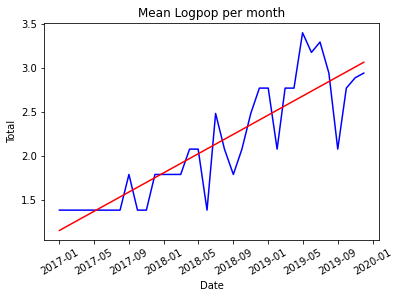

In [123]:
sns.lineplot(x='Date', y='Total', data=log_mean, color='blue')
total_logmean_linear_model = LinearRegression(fit_intercept=True)
total_logmean_linear_model.fit(np.reshape((log_mean.Date - log_mean.Date.min()).apply(lambda x: x.days).values, 
                               (-1, 1)), 
                                log_mean.Total.values)
sns.lineplot(x=log_mean.Date.values, y=total_logmean_linear_model.predict(
                                np.reshape((log_mean.Date - log_mean.Date.min()).apply(lambda x: x.days).values, 
                               (-1, 1))).flatten(), color='red')
plt.xticks(rotation=30)
plt.title('Mean Logpop per month')
plt.show()

In [124]:
total_logmean_linear_model.coef_, total_logmean_linear_model.intercept_

(array([0.00179572]), 1.1555974979319816)

In [125]:
# Remove features that have NaNs.
log_features_df, tsfresh_feature_names = \
            clean_nan_features(log_features_df, colname=feature_type_to_use,
                            feature_names=tsfresh_feature_names)

In [126]:
# Run skills_to_indices to generate indices.
df_x_datapoints_with_ground_truth, df_y_all, df_x_all, datapoints_all_indices = \
                        skills_to_indices(log_features_df, y_reformatted)

     Skill                                            tsfresh  \
0     .net  [1218.3062918954456, 11.604588911528042, 5.0, ...   
3414  .net  [3184.0929828210164, 40.18063636215955, 12.0, ...   
4294  .net  [11715.652426500506, 93.4907103705558, 9.0, 25...   
684   .net  [1596.9736452000684, 21.4964311337057, 6.0, 4....   
2445  .net  [10128.533088879558, 74.80650514210194, 9.0, 1...   

                                     linreg_nointercept  Job Postings Raw  \
0     [-0.00352615736152837, -0.007705333847019113, ...               285   
3414  [0.4045424849282452, -0.013775290198050787, 1....               642   
4294  [-0.4032666419605481, 0.026471055350304678, 2....              1307   
684   [0.3215400235714287, -0.04955272331825384, 1.2...               357   
2445  [0.7413892060122662, 0.008915952736550662, 2.0...              1022   

     time_period      common_key  
0      2017-2018  .net_2017-2018  
3414   2017-2019  .net_2017-2019  
4294   2017-2020  .net_2017-2020  
684   

In [127]:
df_x_datapoints_with_ground_truth[feature_type_to_use].values[0].size

24

In [2380]:
from sklearn.feature_selection import f_classif
temp_df = pd.merge(df_x_datapoints_with_ground_truth, df_y_all[['common_key', 'row_class']])
f_scores, f_pvals = f_classif(series_to_matrix(temp_df.tsfresh), 
     temp_df.row_class.values)

/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [5 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [2151]:
f_scores = [(tsfresh_feature_names[i], f_scores[i]) for i in range(len(f_scores))]
f_scores = (sorted(f_scores, key = lambda x: x[1]))[::-1]
print(f_scores[:20])

[('quantile__q_0.2', 34.80636780747113), ('quantile__q_0.3', 34.3068340877767), ('quantile__q_0.4', 33.727437616107274), ('minimum', 33.50298561314346), ('quantile__q_0.6', 32.02226113447318), ('quantile__q_0.7', 31.468111954111144), ('variance_larger_than_standard_deviation', 31.339788394179447), ('large_standard_deviation__r_0.30000000000000004', 17.12756659283683), ('large_standard_deviation__r_0.2', nan), ('agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"', nan), ('agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"intercept"', 34.519545259150355), ('quantile__q_0.1', 34.33336203957334), ('median', 32.912010230715005), ('mean', 32.479646875119), ('quantile__q_0.8', 31.160929570934606), ('quantile__q_0.9', 30.705122338827447), ('maximum', 29.006130217122422), ('absolute_sum_of_changes', 21.705970645783633), ('standard_deviation', 19.6692552216106), ('abs_energy', 13.052298287426828)]


In [2152]:
df_y_all.head()

,Skills,row_class,common_key,common_index
0,.net,0,.net_2017-2018,0
987,.net,0,.net_2018-2019,1
1,3d graphics,0,3d graphics_2017-2018,2
988,3d graphics,0,3d graphics_2018-2019,3
2,3d modeling,0,3d modeling_2017-2018,4


In [2153]:
# Create train/test split and then perform pre-normalisation and PCA.
sampled_train_x_df, sampled_test_x_df, sampled_train_y_df, sampled_test_y_df = \
    create_train_test_split(df_x_datapoints_with_ground_truth, df_y_all, 
                            test_proportion=0.3, based_on_year=True, class_balanced=False, random_state=1)

sampled_train_x_df, sampled_test_x_df, pca_model, pre_normaliser, throwaway, feature_selection_model = \
    pre_normalise_and_pca(sampled_train_x_df, sampled_test_x_df, sampled_train_y_df, sampled_test_y_df,
             n_pca_features=20, n_selection_features=None, pre_normaliser=RobustScaler(quantile_range=(5,95)),
                 post_normaliser=None, pca_first=True)

Creating train/test split
2018-2019
801672


Let's see how many members each class has.

In [667]:
sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,774
1,213


In [668]:
len(sampled_train_x_df.tsfresh.values[0])

20

In [669]:
sampled_test_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,843
1,144


In [670]:
df_y_all.shape, len(df_y_all.loc[df_y_all.row_class == 1].Skills.unique()), sampled_train_y_df.shape

((1974, 4), 291, (987, 4))

In [671]:
# Run generate_cv_folds on the training data to get... cv folds.
resulting_dfs = generate_cv_folds(sampled_train_x_df, sampled_train_y_df, stratified=False)

### Computation (training and validation)

In [1749]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [1356]:
# Run cross_validate_with_quantile with the appropriate feature column name. 
# Set C_LIST and QUANTILES through utilities/params.py
# normaliser = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(40, 60))
# normaliser = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5, 95))
# normaliser = RobustScaler(with_scaling=False)
# normaliser = RobustScaler(with_scaling=False, with_centering=False)
# normaliser = StandardScaler(with_std=False)
normaliser = StandardScaler(with_std=True)
best_model, best_c, best_q, best_score, rawpop_upper_bound_dict = \
    cross_validate_with_quantile(resulting_dfs, log_features_df, normaliser=normaliser, 
             features_col=feature_type_to_use, c_list= np.logspace(start=-5, stop=5, num=11, base=10), 
                                 quantiles=np.linspace(0.8, 0.95, num=4), model_to_use='logreg', 
                                 eval_type='f1', aggregated_skills=False)

tsfresh
QUANTILE: 0.8

-----------


C: 1e-05

-----------


Avg score: 0.0

**********


C: 0.0001

-----------


Avg score: 0.0

**********


C: 0.001

-----------


Avg score: 0.0

**********


C: 0.01

-----------


Avg score: 0.34977923731101856

**********


C: 0.1

-----------


Avg score: 0.47918481009991937

**********


C: 1.0

-----------


Avg score: 0.48714852351949134

**********


C: 10.0

-----------


Avg score: 0.4966606045403236

**********


C: 100.0

-----------


Avg score: 0.5063894275658982

**********


C: 1000.0

-----------


Avg score: 0.5116512674721629

**********


C: 10000.0

-----------




KeyboardInterrupt: 

In [ ]:
print(best_model, best_c, best_q, best_score)

## Bulk training

In [204]:
all_results = {random_state: normalise_pca_and_cross_validate_wrap(df_x_datapoints_with_ground_truth, df_y_all,
                          log_features_df, [10,20,40,60,80], n_selection_features=None, test_proportion=0.3, 
                          based_on_year = True, also_based_on_skill=False,
                          pre_pca_norms = [RobustScaler(quantile_range=(2.5,97.5)),
                                           RobustScaler(quantile_range=(5,95))],
                           pre_clf_norms = [StandardScaler()],
                               verbose=False, features_col=feature_type_to_use,
                                  c_list=np.logspace(start=-4, stop=4, num=9, base=10), 
                                      quantiles=
                                                                   np.linspace(0.8, 1, num=5), 
                                       model_to_use='logreg', 
                                          eval_type='f1',
                                              random_state=random_state,
                                                  common_keys_to_keep=common_keys_to_keep)
                                                   for random_state in range(1,2)}

Random state: 1
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: f1 = 0.5399134199134199
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: f1 = 0.5265191257539525
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: f1 = 0.5208902572454839
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: f1 = 0.5401286116983791
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: f1 = 0.5240948833297101
Creating train/test split
2018-2019
308295
tsfresh
Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
P

In [193]:
results_tf321_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_4 = all_results
with open('results_tf321_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_4.pkl', 'wb') as f:
    pickle.dump(results_tf321_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_4, f)

### Evaluation (test and manual investigation)

### Test set:

**Regular eval**

In [1702]:
results_tf331_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_3

{1: ({0: ((LogisticRegression(max_iter=5000), StandardScaler()),
    1.0,
    0.8,
    0.49452029452029456,
    {'2017-2018': 38.0,
     '2018-2019': 77.0,
     '2019-2020': 130.0,
     '2018-2020': 181.0,
     '2017-2019': 103.40000000000009,
     '2017-2020': 205.80000000000007},
    RobustScaler(quantile_range=(2.5, 97.5)),
    [PCA(n_components=10), None]),
   1: ((LogisticRegression(C=10.0, max_iter=5000), StandardScaler()),
    10.0,
    0.8,
    0.5067541280722392,
    {'2017-2018': 38.0,
     '2018-2019': 77.0,
     '2019-2020': 130.0,
     '2018-2020': 181.0,
     '2017-2019': 103.40000000000009,
     '2017-2020': 205.80000000000007},
    RobustScaler(quantile_range=(2.5, 97.5)),
    [PCA(n_components=20), None]),
   2: ((LogisticRegression(max_iter=5000), StandardScaler()),
    1.0,
    0.8,
    0.49287513076986766,
    {'2017-2018': 38.0,
     '2018-2019': 77.0,
     '2019-2020': 130.0,
     '2018-2020': 181.0,
     '2017-2019': 103.40000000000009,
     '2017-2020': 205.8000

In [1703]:
best_model = results_tf331_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_3[1][0][4][0]
best_q = results_tf331_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_3[1][0][4][2]

In [1704]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
test_y_pred, test_y_eval, test_pred_positive_df, test_actual_positive_df, test_all_pred = \
            predict_and_evaluate_dfs(best_model[0], sampled_test_x_df, sampled_test_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                         features_col=feature_type_to_use, 
                         normaliser=best_model[1], eval_type='prfs', return_modified_df=True)

test_y_pred, test_y_eval, test_pred_positive_df, test_actual_positive_df

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [1705]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(test_pred_positive_df)

,Skills,row_class,common_key,common_index,pred
71,apache mxnet,0,apache mxnet_2018-2019,143,1.0
80,apache tomcat,1,apache tomcat_2018-2019,161,1.0
96,as400 system,1,as400 system_2018-2019,193,1.0
104,autocad architecture,0,autocad architecture_2018-2019,209,1.0
109,autodesk maya & pixar renderman,0,autodesk maya & pixar renderman_2018-2019,219,1.0
117,autosys,0,autosys_2018-2019,235,1.0
120,awk (programming language),0,awk (programming language)_2018-2019,241,1.0
121,axure rp,0,axure rp_2018-2019,243,1.0
150,building management system,1,building management system_2018-2019,301,1.0
159,capa,0,capa_2018-2019,319,1.0


**Aggregated eval**

In [1728]:
predict_and_evaluate_dfs(best_model[0], sampled_test_x_df, sampled_test_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                         features_col=feature_type_to_use, 
                         normaliser=best_model[1], eval_type='prfs', return_modified_df=True, 
                         aggregate_for_skills=True)

(0      0
 1      1
 2      1
 3      1
 4      1
       ..
 982    0
 983    1
 984    1
 985    0
 986    1
 Name: pred, Length: 987, dtype: int64,
 (0.21143847487001732, 0.9682539682539683, 0.3470839260312944, None),
                Skills  row_class  pred
 1         3d graphics          0     1
 2         3d modeling          0     1
 3         a/b testing          0     1
 4           ab initio          0     1
 8    active directory          0     1
 ..                ...        ...   ...
 979            zabbix          0     1
 980            zbrush          0     1
 983          zeppelin          0     1
 984            zeromq          0     1
 986              zuul          0     1
 
 [577 rows x 3 columns],
                              Skills  row_class  pred
 18             adobe creative suite          1     1
 23                   adobe indesign          1     1
 25                    adobe marketo          1     1
 28               adobe premiere pro          1     1
 38

### Comparing to baselines

**Regular eval**

In [660]:
evaluate_results(np.array([1]*sampled_test_y_df.shape[0]), sampled_test_y_df[TRUTH_COL].values, eval_type='prfs')

(0.12837837837837837, 1.0, 0.22754491017964074, None)

In [661]:
np.mean([evaluate_results((np.random.rand(sampled_test_y_df.shape[0])<
                (sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count().iloc[1].values[0]/
                                 sampled_train_y_df.shape[0])).astype(int), 
                 sampled_test_y_df[TRUTH_COL].values, eval_type='prfs')[:3] for x in range(200)], axis=0)

array([0.11998775, 0.11973684, 0.11906157])

**Aggregated eval**

In [662]:
agg_test_gt = sampled_test_y_df[['Skills', 'row_class']].groupby('Skills').\
                 apply(lambda x: 1 if x['row_class'].sum() > 0 else 0)\
                 .values

In [663]:
evaluate_results(np.array([1]*len(sampled_test_y_df.Skills.unique())), agg_test_gt
                 , eval_type='prfs')

(0.12837837837837837, 1.0, 0.22754491017964074, None)

In [664]:
np.mean([evaluate_results((np.random.rand(len(agg_test_gt)) < np.sum(agg_test_gt)/len(agg_test_gt)).astype(int), 
                 agg_test_gt, eval_type='prfs')[:3] for x in range(200)], axis=0)

array([0.1289356 , 0.13118421, 0.12928478])

### Training set:

In [206]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
train_y_pred, train_y_eval, train_pred_positive_df, train_actual_positive_df, train_all_pred = \
            predict_and_evaluate_dfs(best_model[0], sampled_train_x_df, sampled_train_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                        normaliser=best_model[1], eval_type='prfs', features_col=feature_type_to_use, 
                         return_modified_df=True)

train_y_pred, train_y_eval, train_pred_positive_df, train_actual_positive_df

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [193]:
evaluate_results(np.array([1]*sampled_train_y_df.shape[0]), sampled_train_y_df[TRUTH_COL].values, eval_type='prfs')

(0.18135764944275581, 1.0, 0.30703259005145794, None)

In [194]:
predict_and_evaluate_dfs(best_model[0], sampled_train_x_df, sampled_train_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                        normaliser=best_model[1], eval_type='prfs', features_col=feature_type_to_use, 
                         return_modified_df=True, aggregate_for_skills=True)

(0      0
 1      0
 2      1
 3      1
 4      0
       ..
 982    0
 983    0
 984    0
 985    0
 986    0
 Name: pred, Length: 987, dtype: int64,
 (0.6470588235294118, 0.30726256983240224, 0.4166666666666667, None),
                     Skills  row_class  pred
 2              3d modeling          1     1
 3              a/b testing          1     1
 18    adobe creative suite          0     1
 25           adobe marketo          1     1
 50               animation          1     1
 ..                     ...        ...   ...
 895  transactional systems          0     1
 899                 ubuntu          0     1
 937                vsphere          1     1
 971                xamarin          0     1
 977                    xsl          1     1
 
 [85 rows x 3 columns],
               Skills  row_class  pred
 2        3d modeling          1     1
 3        a/b testing          1     1
 15   adobe analytics          1     0
 23    adobe indesign          1     0
 25     adobe marke

# Model interpretation

## Feature weights
These are the raw weights. With a pre- and post-PCA normalised set of features, these are good indicators of a feature's importance. A positive coefficient means that datapoints with larger values in that feature are more likely to be classified as positive, whereas a negative coefficient means that those are more likely to be classified as negative. The unintuitive side of this fact is that the values of positive class datapoints for a feature with a negative coefficient could be larger negative numbers than the values of the negative class datapoints for said feature. Either way, these are very useful, but an alternative way of interpreting the discriminative power of each feature to the positive class can be seen in the next section.

In [1707]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model, n_features=None,
                           dataframes=(sampled_train_x_df.tsfresh, sampled_test_x_df.tsfresh), 
                            normaliser=best_model[1]))
# interpret_model(best_model[0], FEATURE_NAMES[feature_type_to_use])

,Name,Score,Features,train_median,test_median,train_std,test_std
1,0,0.697460,"[(time_reversal_asymmetry_statistic__lag_1, 0.6444413348681308), (time_reversal_asymmetry_statistic__lag_2, 0.5306989284540639), (time_reversal_asymmetry_statistic__lag_3, 0.5142624688915022), (abs_energy, 0.15262655642548553), (variance, 0.050443101080389345), (minimum, 0.03392744984160839), (quantile__q_0.1, 0.033324866297571094), (quantile__q_0.2, 0.03222630911885502), (mean, 0.0319366822426646), (quantile__q_0.9, 0.03149313458142868), (maximum, 0.030849127317550646), (quantile__q_0.3, 0.030829367385679186), (median, 0.03022980156353637), (quantile__q_0.4, 0.03020667701839308), (quantile__q_0.7, 0.03016419264786869), (quantile__q_0.6, 0.030121481011373435), (quantile__q_0.8, 0.02990619930181395), (standard_deviation, 0.0211495312270623), (absolute_sum_of_changes, 0.020045532706226984), (variance_larger_than_standard_deviation, 0.011232415325369616)]",-1.002895,-1.012121,0.056859,0.119903
2,1,0.620711,"[(abs_energy, 0.4467432876694668), (time_reversal_asymmetry_statistic__lag_2, -0.36545584159821226), (time_reversal_asymmetry_statistic__lag_1, 0.32481573699483635), (time_reversal_asymmetry_statistic__lag_3, -0.31982764502961003), (minimum, 0.19053465156972693), (quantile__q_0.2, 0.18843199248807024), (quantile__q_0.1, 0.18837234995645646), (mean, 0.18605872537200974), (quantile__q_0.3, 0.18472056987294183), (median, 0.18295294668842782), (quantile__q_0.6, 0.18248869665859743), (quantile__q_0.4, 0.18234735827609133), (quantile__q_0.7, 0.1821705254858165), (quantile__q_0.8, 0.17683725355289623), (quantile__q_0.9, 0.174327631267091), (maximum, 0.1691212568737536), (absolute_sum_of_changes, 0.15768477201762943), (variance, 0.11827770732284425), (standard_deviation, 0.10533398456297999), (variance_larger_than_standard_deviation, 0.0924964138301525)]",-0.610879,-0.740150,0.570628,0.886148
7,6,0.523905,"[(longest_strike_above_mean, -0.6287608271439605), (longest_strike_below_mean, -0.6007648588749022), (variance, 0.28021969106800615), (variance_larger_than_standard_deviation, -0.2735265453877905), (abs_energy, 0.19028278422690248), (absolute_sum_of_changes, 0.09821150891701574), (standard_deviation, -0.09655896149616477), (quantile__q_0.8, -0.07303421231511704), (quantile__q_0.7, -0.06305589668652183), (quantile__q_0.9, -0.06002155375629886), (time_reversal_asymmetry_statistic__lag_1, -0.05657865485179233), (quantile__q_0.6, -0.055475138107465426), (time_reversal_asymmetry_statistic__lag_3, 0.05274477328548098), (maximum, -0.049850860300936536), (median, -0.04828613272232358), (mean, -0.047823881383681884), (quantile__q_0.4, -0.03619131793403296), (minimum, -0.030627379698542574), (quantile__q_0.1, -0.028148157446046828), (time_reversal_asymmetry_statistic__lag_2, -0.02767571493405831)]",-0.001756,0.733604,2.213636,2.794225
0,s_min,0.491842,None,0.000000,0.000000,0.000000,0.000000
16,15,0.274016,"[(minimum, -0.5851834293712177), (quantile__q_0.1, 0.5672363994370936), (quantile__q_0.2, 0.3624342722089357), (quantile__q_0.4, -0.31193162162064864), (quantile__q_0.9, -0.17422843576119224), (quantile__q_0.6, 0.15483602072922695), (maximum, 0.11722798207187991), (quantile__q_0.7, 0.10390493371840985), (median, -0.09879540251954724), (quantile__q_0.3, -0.08893796737859584), (absolute_sum_of_changes, -0.05892380474074939), (standard_deviation, 0.05399322530336197), (quantile__q_0.8, -0.05212739924989084), (time_reversal_asymmetry_statistic__lag_2, -0.02685830529886939), (time_reversal_asymmetry_statistic__lag_3, 0.02553053785978566), (count_above_mean, 0.0060912594974307285), (variance, -0.005522702591068657), (abs_energy, 0.004829552442260293), (longest_strike_above_mean, -0.004354951206045298), (longest_strike_below_mean, -0.0034577207887100353)]",-0.026648,0.150082,0.310908,0.568113
12,11,0.255233,"[(absolute_sum_of_changes, 0.6576452223800211), (standard_deviation, -0.5709708606565553), (quantile__q_0.9, -0.22213466403804155), (quantile__q_0.8, -0.2072896982

Let's compute an ad-hoc importance measure for each _original_ feature.

In [1708]:
from itertools import chain

interpretations = interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model, n_features=None,
                           dataframes=(sampled_train_x_df.tsfresh, sampled_test_x_df.tsfresh), 
                            normaliser=best_model[1]).drop(0, axis=0)
interpretations['Features'] = interpretations.apply(lambda x: [(y[0], y[1]*x['Score']) for y in x['Features']], 
                                                   axis=1)
important_originals = list(chain.from_iterable(interpretations['Features'].values.tolist()))
important_originals = pd.DataFrame({'Original Feature': [x[0] for x in important_originals], 
                                    'Ad-hoc Importance': [x[1] for x in important_originals]})
important_originals = important_originals.groupby('Original Feature').\
                                sum().sort_values('Ad-hoc Importance', ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(important_originals)

,Ad-hoc Importance
Original Feature,
time_reversal_asymmetry_statistic__lag_1,0.639056
quantile__q_0.1,0.633322
quantile__q_0.3,0.571467
abs_energy,0.291840
quantile__q_0.4,0.280190
variance,0.263812
quantile__q_0.7,0.262339
time_reversal_asymmetry_statistic__lag_2,0.220811
quantile__q_0.9,0.161363


## Feature importance based on separation of distributions and contribution to score

In [549]:
all_preds = pd.concat([test_all_pred, train_all_pred]).sort_values('common_index')
all_preds_x_values = pd.concat([sampled_train_x_df, sampled_test_x_df])
all_preds_x_values = all_preds_x_values.loc[all_preds_x_values.common_index.apply(
                    lambda x: x in all_preds.common_index.values)].sort_values('common_index')
all_preds_x_values['tsfresh'] = best_model[1].transform(
                            series_to_matrix(all_preds_x_values['tsfresh'])).tolist()
all_preds_x_values = pd.merge(all_preds_x_values, all_preds[['common_index', 'pred']], on='common_index')

NameError: name 'train_all_pred' is not defined

In [550]:
quantiles_for_spread = (0.25, 0.75)
positive_centre = np.median(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 'tsfresh']), 
                            axis=0)
negative_centre = np.median(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 'tsfresh']),
                            axis=0)
positive_spread = np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 
                              'tsfresh']), quantiles_for_spread[1]) - \
                    np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 
                                                                    'tsfresh']), quantiles_for_spread[0])
negative_spread = np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 
                              'tsfresh']), quantiles_for_spread[1]) - \
                    np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 
                                                                    'tsfresh']), quantiles_for_spread[0])
importance_measure = best_model[0].coef_ * ((positive_centre - negative_centre)/(positive_spread*negative_spread))

NameError: name 'all_preds_x_values' is not defined

In [105]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, feature_scores=importance_measure, 
                           pca_model=pca_model, n_features=None,
                           dataframes=(sampled_train_x_df.tsfresh, sampled_test_x_df.tsfresh), 
                           normaliser=best_model[1]))

,Name,Score,Features,train_median,test_median,train_std,test_std
2,1,5.445419,"[(variance, 0.7481472540955625), (abs_energy, -0.43315981999170367), (standard_deviation, 0.3142859934067503), (absolute_sum_of_changes, 0.25648770170933965), (maximum, 0.1835231655900462), (variance_larger_than_standard_deviation, 0.16955597148493806), (mean, 0.10283397207153205), (median, 0.08158338417868047), (longest_strike_below_mean, 0.06496647674834145), (minimum, 0.04893240475969718), (longest_strike_above_mean, -0.04255528471423913)]",-0.037560,0.402257,1.953131,4.135073
0,s_min,0.849052,None,0.000000,0.000000,0.000000,0.000000
3,2,0.803045,"[(variance, 0.5332513779548429), (median, -0.35555663450512653), (mean, -0.34136856312958364), (minimum, -0.3400032009491903), (absolute_sum_of_changes, -0.3267252799172213), (abs_energy, 0.27548253105807957), (maximum, -0.2630157206114085), (variance_larger_than_standard_deviation, -0.23975534269818852), (longest_strike_below_mean, 0.15541606549280534), (longest_strike_above_mean, 0.11722179696137267), (standard_deviation, -0.09946227841479498)]",-0.137719,0.290405,2.293611,2.798096
6,5,0.068681,"[(variance_larger_than_standard_deviation, -0.8294216564264107), (minimum, 0.2770687113528524), (longest_strike_below_mean, 0.24906254842785053), (median, 0.23237157086773935), (mean, 0.2123687307807312), (standard_deviation, -0.16782068744608714), (longest_strike_above_mean, 0.12644948148522828), (abs_energy, -0.117840350541222), (maximum, 0.10109107947962588), (variance, 0.07668426028919305), (absolute_sum_of_changes, 0.004897183364893504)]",0.095158,-1.274863,1.694258,2.055282
9,8,0.052213,"[(median, -0.6685542391138626), (minimum, 0.5389101366900617), (maximum, 0.43145596385854057), (mean, -0.26153885204645283), (absolute_sum_of_changes, 0.06020861682001871), (standard_deviation, -0.04509206691606393), (variance, -0.033334057568196906), (longest_strike_above_mean, 0.030865252888484674), (variance_larger_than_standard_deviation, -0.01245257039954096), (longest_strike_below_mean, -0.010300583824485638), (abs_energy, -0.008420822528225473)]",0.001092,-0.717364,1.589890,1.951003
11,10,0.035102,"[(mean, 0.7838265496293695), (median, -0.48054087354911296), (minimum, -0.3376561327246811), (standard_deviation, -0.1463335107766761), (maximum, 0.13827051485121333), (absolute_sum_of_changes, -0.011749233127868023), (longest_strike_above_mean, 0.0033347700450723668), (longest_strike_below_mean, -0.0014059086231825726), (variance, -0.0009799901857837096), (abs_energy, 0.0004919344869666866), (variance_larger_than_standard_deviation, -0.0004113332361474953)]",-0.022631,0.465644,1.442918,1.898462
5,4,-0.009963,"[(longest_strike_above_mean, -0.6569494070445767), (longest_strike_below_mean, -0.6553713734317775), (variance_larger_than_standard_deviation, -0.30120826416720653), (variance, 0.13508401093207745), (standard_deviation, -0.11214834417756198), (absolute_sum_of_changes, 0.10111881764021118), (maximum, -0.05005819836676904), (mean, -0.04484174773120058), (median, -0.0404222654934404), (minimum, -0.02574009067834776), (abs_energy, 0.01778615461571968)]",-0.098407,0.405046,1.681245,1.969549
10,9,-0.020334,"[(maximum, -0.7669453571348742), (minimum, 0.4618828989309645), (standard_deviation, 0.28399914448395), (mean, 0.2452513085267311), (median, -0.23309296755683553), (absolute_sum_of_changes, 0.056880263472779344), (variance, 0.008466753434020802), (abs_energy, -0.003081841196071262), (variance_larger_than_standard_deviation, 0.0022326642066779305), (longest_strike_above_mean, -0.0011925280940338595), (longest_strike_below_mean, 4.442892475760104e-05)]",-0.065887,-0.443662,1.316251,1.871513
8,7,-0.049796,"[(standard_deviation, -0.7089385479902662), (absolute_sum_of_changes, 0.6184545885412095), (maximum, -0.22434842423211637), (variance_larger_than_standard_deviation, 0.16185854675743727), (variance, 0.1177662310069834), (longest_strike_below_mean, 0.11012225214038739), (longest_strike_above_mean, 0.07809438216903342),

In [6842]:
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'agg_autocorrelation__f_agg_"median"__maxlag_40',
 'agg_autocorrelation__f_agg_"var"__maxlag_40',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"int

### Seeing the top n data points for each feature

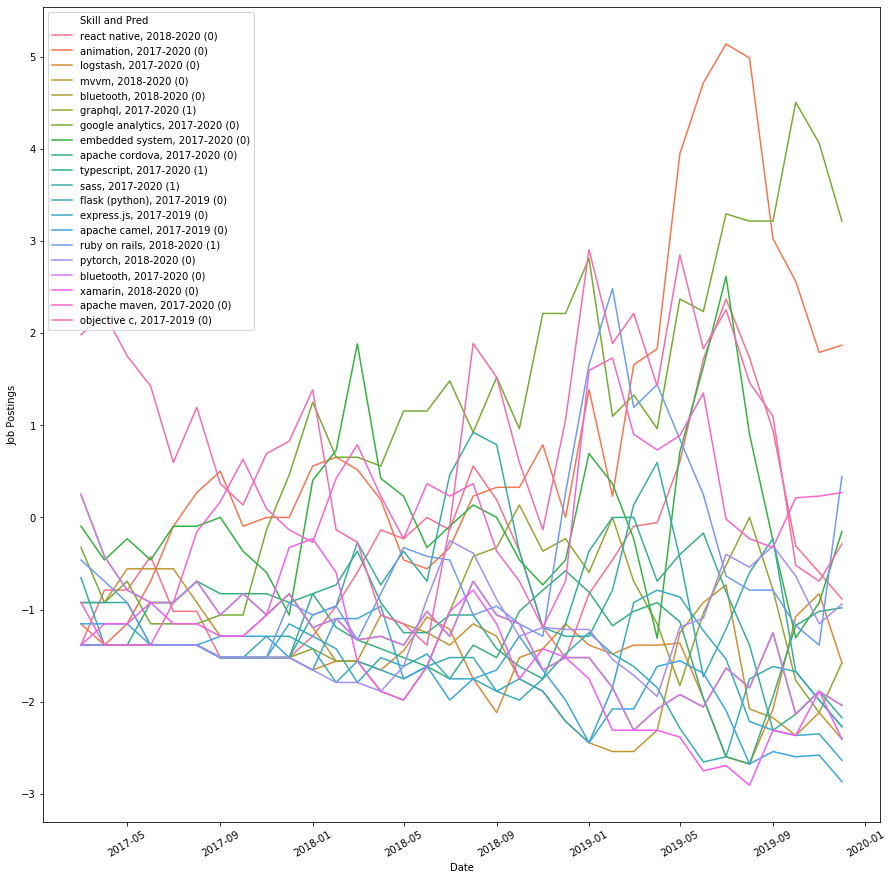

In [6844]:
feature_number = 49
n_skills_to_get = 20
preds_to_get = 'both'
pos_neg_or_both = 'both'
no_superstars = True

if no_superstars:
    preds_to_look_at = all_preds_x_values.loc[all_preds_x_values.apply(lambda x: 
                                       x['Job Postings Raw'] <= rawpop_upper_bound_dict[x['time_period']], axis=1)]
else:
    preds_to_look_at = all_preds_x_values

if preds_to_get == 'pos':
    preds_to_look_at = preds_to_look_at.loc[preds_to_look_at.pred == 1]
elif preds_to_get == 'neg':
    preds_to_look_at = preds_to_look_at.loc[preds_to_look_at.pred == 0]
else:
    preds_to_look_at = preds_to_look_at

if pos_neg_or_both == 'pos':
    top_datapoints = (np.argsort(series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number])[-n_skills_to_get:])[::-1].flatten()
elif pos_neg_or_both == 'neg':
    top_datapoints = (np.argsort(-series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number])[-n_skills_to_get:])[::-1].flatten()
else:
    top_datapoints = (np.argsort(np.abs(series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number]))[-n_skills_to_get:])[::-1].flatten()
top_skills = preds_to_look_at.iloc[top_datapoints].common_key.values
top_skill_labels = preds_to_look_at.iloc[top_datapoints].pred.values
skill_to_label = {top_skills[i]: top_skill_labels[i] for i in range(len(top_skills))}
multi_skill_df = multiple_skill_pop_profiles(group_time_steps_together(skills_df, 1, True), 
                                           top_skills, 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg')
multi_skill_df['Skill and Pred'] = multi_skill_df['common_key'].apply(lambda x: 
                                                                 x.replace('_', ', ') + 
                                                                      ' (' + str(int(skill_to_label[x])) + ')')
ax = plt.figure(num=1, figsize=(15,15))
sns.lineplot(x='Date', y='Job Postings', data=multi_skill_df, hue='Skill and Pred')
# plt.hlines(one_skill_df['Job Postings'].mean(), 
#            TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
# sns.lineplot(x='Date', y='Total', data=log_mean.assign(Total=-log_mean.Total), markers=['dashdot'], color='black')
plt.xticks(rotation=30)
plt.show()

In [6845]:
preds_to_look_at.iloc[top_datapoints].assign(chosen_feature=
         preds_to_look_at.iloc[top_datapoints].apply(lambda x: x['tsfresh'][feature_number], axis=1))[
                ['Skill', 'common_key', 'chosen_feature', 'pred']]

,Skill,common_key,chosen_feature,pred
336,react native,react native_2018-2020,-3.177515,0.0
32,animation,animation_2017-2020,2.943686,0.0
232,logstash,logstash_2017-2020,-2.498228,0.0
253,mvvm,mvvm_2018-2020,-2.412980,0.0
80,bluetooth,bluetooth_2018-2020,-2.408855,0.0
172,graphql,graphql_2017-2020,2.391237,1.0
166,google analytics,google analytics_2017-2020,-2.325102,0.0
139,embedded system,embedded system_2017-2020,2.315722,0.0
44,apache cordova,apache cordova_2017-2020,-2.277661,0.0
408,typescript,typescript_2017-2020,2.260462,1.0


In [6846]:
tsfresh_feature_name_map = invert_dict(dict(enumerate(tsfresh_feature_names)))
log_features_df['2017-2020'].reset_index().assign(abs_energy=log_features_df['2017-2020'].reset_index().
                                    tsfresh.apply(lambda x: x[tsfresh_feature_name_map['abs_energy']])).loc[
                                            log_features_df['2017-2020'].reset_index().Skill.apply(lambda x: 
                                                    x in preds_to_look_at.iloc[top_datapoints].Skill.values)].\
                                                        sort_values('abs_energy', ascending=False)

,Skill,tsfresh,linreg_nointercept,Job Postings Raw,abs_energy
393,google analytics,"[130.59372116377176, 16.44769703957372, -0.532...","[0.11450729166267967, 0.0008249055024745567, 3...",187,130.593721
50,animation,"[127.63046415750726, 17.69093085578512, -0.348...","[0.02922163197294721, 0.0027482389960488975, 5...",178,127.630464
59,apache camel,"[109.14248386477715, 7.0316947553128655, -0.47...","[0.010207913950346616, -0.001401274116363851, ...",20,109.142484
971,xamarin,"[104.40583967644426, 9.373164689065774, -0.282...","[0.012059171030254463, -0.0017045760595774209,...",27,104.405840
340,express.js,"[98.91790813966098, 6.413304929650924, -0.2099...","[0.0118719203672541, -0.0008850443982374036, 0...",25,98.917908
356,flask (python),"[97.92316884306622, 6.543942954560857, -0.3801...","[-0.03348551784250303, 0.00019851977544435765,...",27,97.923169
612,mvvm,"[87.55289173884813, 8.719278520391288, -0.3387...","[-0.06378636340073464, 0.0005115091463524638, ...",36,87.552892
523,logstash,"[85.38745612444885, 7.39413418266265, -0.02801...","[-0.012846210828748364, 0.00012006552991040734...",39,85.387456
645,objective c,"[70.52151193804877, 24.225219233275446, -0.090...","[-0.07346883397763616, 0.001960410199326955, 3...",170,70.521512
143,bluetooth,"[68.63198817171002, 9.455827552836215, -0.5270...","[-0.07163026811617279, 0.0006628561586475955, ...",50,68.631988


## Analysing the features of _predicted positives_

In [6847]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [6848]:
all_positive_preds = pd.concat([test_pred_positive_df, train_pred_positive_df]).sort_values('common_index')
all_positive_preds_x_values = pd.concat([sampled_train_x_df, sampled_test_x_df])
all_positive_preds_x_values = all_positive_preds_x_values.loc[all_positive_preds_x_values.common_index.apply(
                    lambda x: x in all_positive_preds.common_index.values)].sort_values('common_index')
all_positive_preds_x_values['tsfresh'] = best_model[1].transform(
                            series_to_matrix(all_positive_preds_x_values['tsfresh'])).tolist()
cluster_model = AgglomerativeClustering(n_clusters=10)
all_positive_preds['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_positive_preds_x_values['tsfresh_orig']))
all_positive_preds_x_values['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_positive_preds_x_values['tsfresh_orig']))

In [6849]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(all_positive_preds.sort_values('cluster'))

,Skills,row_class,common_key,common_index,pred,cluster
8,airflow,1,airflow_2018-2020,8,1.0,0
13,amazon dynamodb,1,amazon dynamodb_2017-2020,13,1.0,0
100,plotly,1,plotly_2017-2020,316,1.0,0
36,apache jmeter,1,apache jmeter_2017-2019,51,1.0,0
248,sass,1,sass_2018-2020,362,1.0,0
43,apache solr,0,apache solr_2017-2020,61,1.0,0
116,scrapy,1,scrapy_2018-2020,371,1.0,0
267,sqlalchemy,1,sqlalchemy_2017-2019,390,1.0,0
91,netbeans,0,netbeans_2017-2020,268,1.0,0
106,f#,1,f#_2017-2020,148,1.0,0


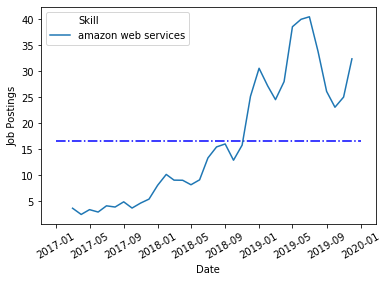

In [6883]:
one_skill_df = investigate_skill_pop_profile(
                    skills_df, 'amazon web services', 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg', ref_for_dates=log_mean)
sns.lineplot(x='Date', y='Job Postings', data=one_skill_df, hue='Skill')
plt.hlines(one_skill_df['Job Postings'].mean(), 
           TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
plt.xticks(rotation=30)
plt.show()

In [6878]:
skills_df.loc[skills_df.Skill == 'plotly']

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
95541,HP,plotly,2018-08-01,1,12,0.083333
95617,HP,plotly,2018-12-01,2,12,0.166667


## Analysing the features of _all predictions_

In [6860]:
cluster_model = AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='ward')
# all_preds['cluster'] = \
#                 cluster_model.fit_predict(series_to_matrix(all_preds_x_values['tsfresh_orig']))
all_preds_x_values['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_preds_x_values['tsfresh']))
all_preds = pd.merge(all_preds, all_preds_x_values[['common_index', 'cluster']], on='common_index')

In [6861]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(all_preds.sort_values('cluster'))

,Skills,row_class,common_key,common_index,pred,cluster
391,statistics,1,statistics_2018-2020,398,0.0,0
256,mysql,0,mysql_2018-2020,260,0.0,0
82,c#,0,c#_2017-2020,85,0.0,0
83,c#,0,c#_2018-2020,86,0.0,0
125,devops,0,devops_2018-2020,128,0.0,0
86,c++,0,c++_2018-2020,89,0.0,0
89,c,0,c_2018-2020,92,0.0,0
124,devops,0,devops_2017-2020,127,0.0,1
26,android,0,android_2017-2020,28,0.0,1
390,statistics,1,statistics_2017-2020,397,0.0,1


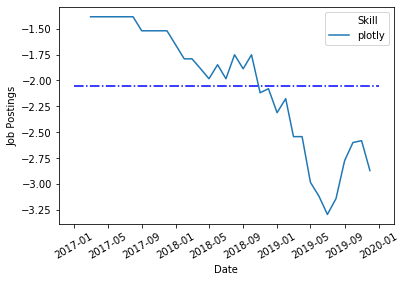

In [6862]:
one_skill_df = investigate_skill_pop_profile(
                    skills_df, 'plotly', 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg', ref_for_dates=log_mean)
sns.lineplot(x='Date', y='Job Postings', data=one_skill_df, hue='Skill')
plt.hlines(one_skill_df['Job Postings'].mean(), 
           TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
plt.xticks(rotation=30)
plt.show()

In [6863]:
pca_model.explained_variance_ratio_

array([4.80992977e-01, 1.51019613e-01, 1.02289893e-01, 5.72507951e-02,
       3.95641432e-02, 2.59825264e-02, 1.83401425e-02, 1.63818370e-02,
       1.20920807e-02, 8.79989404e-03, 8.46187075e-03, 8.14102514e-03,
       6.63922460e-03, 5.64985519e-03, 5.32343172e-03, 4.59289019e-03,
       4.27085132e-03, 3.34128453e-03, 2.61117302e-03, 2.60134699e-03,
       2.38204730e-03, 2.11953486e-03, 1.80442717e-03, 1.77462606e-03,
       1.60120922e-03, 1.43001039e-03, 1.38988084e-03, 1.33206149e-03,
       1.26790157e-03, 9.99821346e-04, 8.78576992e-04, 8.44464837e-04,
       8.20183352e-04, 7.94052177e-04, 6.54570440e-04, 6.08563183e-04,
       5.83239158e-04, 5.37379287e-04, 5.21661338e-04, 4.90982098e-04,
       4.70246853e-04, 4.57643219e-04, 4.38355827e-04, 4.23366001e-04,
       4.13457609e-04, 3.94645991e-04, 3.88556585e-04, 3.67298200e-04,
       3.46587379e-04, 3.35342036e-04, 3.28376145e-04, 3.08736595e-04,
       2.98270578e-04, 2.73063122e-04, 2.66784348e-04, 2.58377099e-04,
      

In [6864]:
np.std(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([38.17119526, 33.61476054,  7.45744292, 26.81305134, 17.35660572,
        4.45552765,  4.11874384,  1.45849045,  4.13869209,  1.90365918,
        2.36257627,  4.37921741,  2.42340881,  1.521722  ,  1.74096477,
        0.9232936 ,  1.31798556,  1.14488464,  1.45071125,  1.64526257,
        1.27782417,  1.68912298,  1.12353779,  1.2165912 ,  1.20883465,
        1.07959687,  1.2929926 ,  1.25357181,  1.63259731,  1.50632285,
        1.09043952,  1.38365668,  1.31824231,  1.57946534,  1.36553297,
        1.29655108,  1.19472969,  1.03196507,  1.07350456,  1.08208119,
        0.95761077,  1.04796219,  1.10003142,  1.14962037,  1.13133657,
        1.22964973,  1.11530925,  1.02634895,  1.12119617,  1.03695269,
        1.00621684,  1.09811352,  1.02501065,  1.2107634 ,  1.14370181,
        1.02378931,  1.21532048,  1.07869983,  0.98294958,  1.12673681])

In [6865]:
np.median(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([ 2.03147257e-01,  3.30471744e-02, -4.68147962e-02, -1.35618567e-01,
       -1.16179572e-01,  1.61195192e-01,  1.59027350e-01, -1.23720229e-02,
       -1.54163707e-03, -5.00838521e-02, -3.05456629e-02, -9.33039669e-03,
        7.48147055e-02, -2.03733167e-02, -8.26939214e-02, -8.34091289e-02,
       -9.25105258e-02, -1.23749917e-01,  2.18260442e-01, -1.12003489e-01,
        6.27012819e-02, -1.60582985e-01, -9.46617346e-02, -3.71129861e-02,
        3.17184602e-02,  1.23860688e-02, -4.90115552e-02, -4.30535297e-02,
       -6.74024806e-02, -1.41538533e-01, -1.86151575e-03,  1.36815691e-01,
        8.29597055e-02, -3.54042004e-02,  2.62874444e-02,  6.33667332e-02,
       -7.62089307e-03, -1.14336019e-04, -4.45729656e-02, -3.66512100e-02,
        6.36521846e-03, -3.67601382e-02, -5.35623314e-02, -8.00493928e-02,
       -7.60841279e-03, -3.83259194e-02, -2.40245089e-02, -3.53672795e-02,
       -1.32385474e-02,  6.21548549e-02, -1.88122138e-02, -4.56242662e-02,
       -7.09762729e-03, -

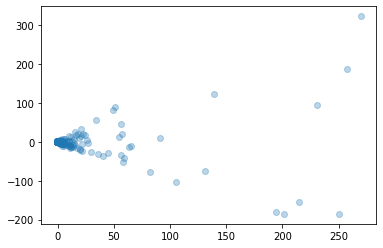

In [6866]:
plt.scatter(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh']))[:,0], 
            best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh']))[:,1], alpha=0.3)

# Predictions for all

In [6867]:
df_x_all_prenormalised = df_x_all.copy().sort_values('common_index')
df_x_all_prenormalised['tsfresh'] = pca_model.transform(pre_normaliser.transform(series_to_matrix(
                                            df_x_all_prenormalised.tsfresh))).tolist()
df_x_all_prenormalised['tsfresh'] = df_x_all_prenormalised['tsfresh'].apply(lambda x: np.array(x))
df_x_all_prenormalised = df_x_all_prenormalised.loc[df_x_all_prenormalised.time_period.apply(lambda x:
                                                    x in ['2017-2019', '2018-2020', '2017-2020'])]
df_x_all_prenormalised['pred'] = best_model[0].predict(best_model[1].transform(
                                    series_to_matrix(df_x_all_prenormalised['tsfresh']))).tolist()
df_x_all_prenormalised['pred'] = df_x_all_prenormalised.apply(lambda x: x['pred'] if x['Job Postings Raw'] 
                                                              < rawpop_upper_bound_dict[x['time_period']] else 0,
                                                              axis=1)
all_skills_predicted_positive_at_some_point = \
                df_x_all_prenormalised.loc[df_x_all_prenormalised.pred == 1, 'Skill'].unique()

In [6868]:
len(df_x_all_prenormalised.loc[df_x_all_prenormalised.pred == 1, 'Skill'].unique()), \
    len(df_x_all_prenormalised['Skill'].unique())

(293, 987)

In [6886]:
df_x_all_prenormalised.loc[(df_x_all_prenormalised.Skill == 'blockchain technology') |
                           (df_x_all_prenormalised.Skill ==  'augmented/virtual reality') |
                           (df_x_all_prenormalised.Skill ==  'business intelligence (bi) tools')]

,Skill,tsfresh,linreg_nointercept,Job Postings Raw,time_period,common_key,common_index,pred
3506,augmented/virtual reality,"[-4.9945348397032925, 0.22102145384945243, -0....","[0.0537200034769486, -0.0019163869430772165, 0...",24,2017-2019,augmented/virtual reality_2017-2019,929,0
4397,augmented/virtual reality,"[-4.867436366074687, 0.27384730030098653, -0.2...","[-0.007215110790682589, 0.0007873658793853278,...",68,2017-2020,augmented/virtual reality_2017-2020,930,0
2548,augmented/virtual reality,"[-4.836128059608177, 0.1409538828441354, -0.39...","[-0.050251565400035086, 0.0030506750287293263,...",63,2018-2020,augmented/virtual reality_2018-2020,932,1
3539,blockchain technology,"[-4.518080066336016, 0.35966753739426666, -1.9...","[-0.16070608540617648, 0.013021877077531439, -...",69,2017-2019,blockchain technology_2017-2019,1121,1
4434,blockchain technology,"[-3.7521181877020147, 1.4078556225524304, -0.4...","[0.2551055668092183, -0.0031514657242227386, 6...",192,2017-2020,blockchain technology_2017-2020,1122,1
2584,blockchain technology,"[-3.99735875557371, -0.4219114175690604, 1.455...","[0.6813479342583325, -0.02232690641742548, 2.5...",185,2018-2020,blockchain technology_2018-2020,1124,0
3550,business intelligence (bi) tools,"[-4.8194392043837215, 0.2521795948240727, -1.3...","[-0.12905328359127402, 0.007442287409513632, -...",49,2017-2019,business intelligence (bi) tools_2017-2019,1183,0
4446,business intelligence (bi) tools,"[-4.088105930585331, 0.7954038138234838, -0.77...","[0.05094605919382861, 0.0022321516899896144, 1...",152,2017-2020,business intelligence (bi) tools_2017-2020,1184,1
2596,business intelligence (bi) tools,"[-3.93171253180279, -0.26569408664350425, -0.4...","[0.4299762549594509, -0.01034242343481067, 4.0...",147,2018-2020,business intelligence (bi) tools_2018-2020,1186,0


In [6870]:
sorted(all_skills_predicted_positive_at_some_point.tolist())

['3d modeling',
 'ab initio',
 'accounting information systems',
 'aconex',
 'adobe cq5',
 'adobe flash',
 'aecosim',
 'ahrefs (seo)',
 'airflow',
 'aix',
 'altera quartus',
 'amazon dynamodb',
 'ampl',
 'anova',
 'apache hive',
 'apache jmeter',
 'apache kafka',
 'apache solr',
 'apache storm',
 'apache web server',
 'api integration',
 'application integration',
 'architecture',
 'as400 system',
 'asr',
 'augmented/virtual reality',
 'autocad',
 'autocad architecture',
 'autodesk maya & pixar renderman',
 'autonomous robot',
 'autosys',
 'aveva',
 'azure active directory connect',
 'backbone.js',
 'bim (building information modeling)',
 'bim management',
 'blockchain technology',
 'boundary conditions',
 'browserify',
 'building automation system',
 'business intelligence (bi) tools',
 'business process mapping',
 'caffe',
 'ceph',
 'cisco unified communications manager architecture (cucm)',
 'citrix xenapp',
 'cloud pbx',
 'cobol',
 'coffeescript',
 'cognos',
 'coldfusion',
 'comput

This isn't nearly as bad as I thought, look at how well it seems to generalise, although there are probably quite a lot of false positives, judging from the fact that over a fourth of the skills are deemed emerging (but then again, in a rapidly growing market, who am I to say some of these aren't emerging?). But the good news is that things like blockchain and augmented reality show up as emerging, and honestly that's really good news.

However, remember the results we had on the test set: this thing has around 50% precision, so we can't fully trust it either.

In [6871]:
sorted(df_x_all_prenormalised.loc[df_x_all_prenormalised.Skill.apply(lambda x: 
                 x not in all_skills_predicted_positive_at_some_point.tolist()), 'Skill'].unique().tolist())

['.net',
 '3d graphics',
 'a/b testing',
 'account management',
 'active directory',
 'active directory federation services (adfs)',
 'adas (architecture design and assessment system)',
 'admission & ticket management',
 'ado.net',
 'adobe acrobat pro',
 'adobe after effects',
 'adobe analytics',
 'adobe campaign',
 'adobe creative suite',
 'adobe dreamweaver',
 'adobe experience manager',
 'adobe illustrator',
 'adobe indesign',
 'adobe lightroom',
 'adobe marketo',
 'adobe phonegap',
 'adobe photoshop',
 'adobe premiere pro',
 'adobe xd',
 'ajax',
 'algorithm design',
 'amazon redshift',
 'amazon web services',
 'aml/cft',
 'amortization',
 'amqp',
 'anaconda',
 'analytical design',
 'android',
 'android sdk',
 'android studio',
 'angularjs',
 'animation',
 'annuity',
 'ansible',
 'ansys',
 'anti-spam programming',
 'anti-virus programming',
 'antlabs',
 'apache ant',
 'apache camel',
 'apache cassandra',
 'apache cordova',
 'apache flume',
 'apache hbase',
 'apache ibatis',
 'apache

In [6872]:
sorted(skills_df.Skill.unique())

['.net',
 '3d graphics',
 '3d modeling',
 'a/b testing',
 'ab initio',
 'account management',
 'accounting information systems',
 'aconex',
 'active directory',
 'active directory federation services (adfs)',
 'adas (architecture design and assessment system)',
 'admission & ticket management',
 'ado.net',
 'adobe acrobat pro',
 'adobe after effects',
 'adobe analytics',
 'adobe campaign',
 'adobe cq5',
 'adobe creative suite',
 'adobe dreamweaver',
 'adobe experience manager',
 'adobe flash',
 'adobe illustrator',
 'adobe indesign',
 'adobe lightroom',
 'adobe marketo',
 'adobe phonegap',
 'adobe photoshop',
 'adobe premiere pro',
 'adobe xd',
 'aecosim',
 'ahrefs (seo)',
 'airflow',
 'aix',
 'ajax',
 'algorithm design',
 'altera quartus',
 'amazon dynamodb',
 'amazon redshift',
 'amazon web services',
 'aml/cft',
 'amortization',
 'ampl',
 'amqp',
 'anaconda',
 'analytical design',
 'android',
 'android sdk',
 'android studio',
 'angularjs',
 'animation',
 'annuity',
 'anova',
 'ansi

In [6873]:
sorted(pickle.load(open('./stackoverflow_majorities.pkl', 'rb')).Skills.unique())

['.htaccess',
 '.net',
 '.net core',
 '3d',
 'active directory',
 'ag grid',
 'aggregation framework',
 'airflow',
 'ajax',
 'algorithm',
 'amazon cloudformation',
 'amazon cloudwatch',
 'amazon cognito',
 'amazon dynamodb',
 'amazon ec2',
 'amazon ecs',
 'amazon elastic beanstalk',
 'amazon rds',
 'amazon redshift',
 'amazon s3',
 'amazon web services',
 'anaconda',
 'android',
 'android activity',
 'android fragments',
 'android intent',
 'android layout',
 'android recyclerview',
 'android room',
 'android studio',
 'angular',
 'angular material',
 'angular reactive forms',
 'angular8',
 'angular9',
 'angularjs',
 'animation',
 'ansible',
 'antd',
 'apache',
 'apache beam',
 'apache camel',
 'apache cassandra',
 'apache cordova',
 'apache flink',
 'apache hive',
 'apache jmeter',
 'apache kafka',
 'apache maven',
 'apache solr',
 'apache spark',
 'apache spark sql',
 'apache tomcat',
 'api',
 'append',
 'architecture',
 'arduino',
 'arm',
 'arraylist',
 'arrays',
 'asp.net',
 'asp.n

## Binpop

### Preprocessing

In [1942]:
# feature_type_to_use = 'linreg_nointercept'
# params_to_use = {feature_type_to_use:{'degree':2}}

params_to_use = {'tsfresh':{}, 'linreg_nointercept':{'degree': 2}}

In [1943]:
# # Run compute_total_poptype_mean with pop_type='bin' (for the normalisation) on original ad df
# bin_mean = compute_total_poptype_mean(skills_df, pop_type='bin')
# # Run compile_all_feature_dfs with pop_type='bin' on skills ad df
# bin_features_df = compile_all_feature_dfs(skills_df, TIME_PERIODS, bin_mean, 
#                                           feature_types=['tsfresh', 'linreg_nointercept'], 
#                                           pop_type='bin', params=params_to_use)
# # # Run skills_to_indices to generate indices.

# # # Run create_train_test_split to create the training and test sets.

# # # Run generate_cv_folds on the training data to get... cv folds.

In [1944]:
# with open('bin_features_df_and_mean.pkl', 'wb') as f:
#     pickle.dump((bin_features_df, bin_mean), f)

In [1945]:
with open('bin_features_df_and_mean.pkl', 'rb') as f:
    bin_features_df, bin_mean = pickle.load(f)

In [1946]:
tsfresh_feature_names = open('../tsfresh_feature_names.txt', 'r').readlines()

In [1947]:
tsfresh_feature_names = [x.strip() for x in tsfresh_feature_names]
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'agg_autocorrelation__f_agg_"median"__maxlag_40',
 'agg_autocorrelation__f_agg_"var"__maxlag_40',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_10__att

In [1949]:
bin_features_df, tsfresh_feature_names = \
            clean_nan_features(bin_features_df, colname='tsfresh',
                            feature_names=tsfresh_feature_names)

In [1950]:
df_x_datapoints_with_ground_truth, df_y_all, df_x_all, datapoints_all_indices = \
                        skills_to_indices(bin_features_df, y_reformatted)

     Skill                                            tsfresh  \
0     .net  [1927.4444444444446, 13.999999999999996, -0.08...   
3414  .net  [4830.0, 45.999999999999986, -0.04185645365114...   
4294  .net  [16232.333333333336, 100.66666666666667, -0.27...   
684   .net  [2272.7777777777783, 23.333333333333332, -0.05...   
2445  .net  [13675.111111111111, 78.0, -0.2343684240755835...   

                                     linreg_nointercept  Job Postings Raw  \
0     [-0.37039963205931054, 0.017174514311322758, 1...               285   
3414  [0.2940865382165749, -0.00999468540069434, 1.3...               642   
4294  [-0.2961716169266051, 0.024758863063801345, 2....              1307   
684   [-0.6775385295402145, 0.03635039218688915, 1.1...               357   
2445  [1.5140547864187057, -0.018861198357340174, 1....              1022   

     time_period      common_key  
0      2017-2018  .net_2017-2018  
3414   2017-2019  .net_2017-2019  
4294   2017-2020  .net_2017-2020  
684   

In [1951]:
df_x_datapoints_with_ground_truth.tsfresh.values[0].size

331

In [1993]:
sampled_train_x_df, sampled_test_x_df, sampled_train_y_df, sampled_test_y_df = \
    create_train_test_split(df_x_datapoints_with_ground_truth, df_y_all, 
                            test_proportion=0.3, class_balanced=True, random_state=5)

sampled_train_x_df, sampled_test_x_df, pca_model, pre_normaliser, throwaway = \
    pre_normalise_and_pca(sampled_train_x_df, sampled_test_x_df, 
                         n_features=50, pre_normaliser=StandardScaler(with_std=False), post_normaliser=None)

Let's see how many members each class has.

In [1994]:
sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,216
1,54


In [1995]:
sampled_test_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,91
1,23


In [1996]:
sampled_train_y_df.shape

(270, 4)

In [1997]:
resulting_dfs = generate_cv_folds(sampled_train_x_df, sampled_train_y_df, stratified=False)

### Computation (training and validation)

In [1998]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [1999]:
feature_type_to_use = 'tsfresh'
# feature_type_to_use = 'linreg_nointercept'

In [2000]:
# Run cross_validate_with_quantile with the appropriate feature column name. 
# Set C_LIST and QUANTILES through utilities/params.py
# normaliser = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(30, 70))
# normaliser = RobustScaler(with_scaling=False)
# normaliser = None
# normaliser = StandardScaler(with_std=False)
normaliser = StandardScaler(with_std=True)
best_model, best_c, best_q, best_score = \
    cross_validate_with_quantile(resulting_dfs, log_features_df, normaliser=normaliser, 
             features_col=feature_type_to_use, c_list= np.logspace(start=-8, stop=7, num=16, base=10), 
                                 eval_type='prec', quantiles=np.linspace(0.80, 0.90, num=3), model_to_use='logreg')

tsfresh
QUANTILE: 0.8

-----------


C: 1e-08

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-07

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-06

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-05

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 0.0001

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.454871794871794

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.505

**********


C: 0.1

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.4883333333333333

**********


C: 1.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.30166666666666664

**********


C: 10.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1]
31
31
54

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.298974358974359

**********


C: 100.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1]
31
31
54

[1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.3113553113553113

*

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.30897435897435893

**********


C: 10000.0

-----------



[0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0]
33
33
53
Avg score: 0.3383333333333333

**********


C: 100000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0]
33
33
53
Avg score: 0.3476923076923077

**********


C: 1000000.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
31
31
54



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]
33
33
53
Avg score: 0.33277777777777773

**********


C: 10000000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
31
31
54



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureW

[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]
33
33
53
Avg score: 0.33277777777777773

**********



QUANTILE: 0.8500000000000001

-----------


C: 1e-08

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 1e-07

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 1e-05

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 0.0001

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.5117460317460317

**********


C: 0.01

-----------



[0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.5384559884559883

**********


C: 0.1

-----------



[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0]
38
38
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.30301587301587307

**********


C: 10.0

-----------



[0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.23857142857142857

**********


C: 100.0

-----------



[0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.28816183816183816

**********


C: 10000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2798913504795858

**********


C: 100000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********


C: 1000000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********


C: 10000000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********



QUANTILE: 0.9

-----------


C: 1e-08

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42


/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur


[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.4504761904761905

**********


C: 1e-07

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.4504761904761905

**********


C: 1e-06

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.42666666666666664

**********


C: 0.0001

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.42666666666666664

**********


C: 0.001

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.44000000000000006

**********


C: 0.1

-----------



[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.36337662337662335


/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.2832539682539682

**********


C: 100.0

-----------



[0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.3280952380952381

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.3025

**********


C: 10000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 1 0 0]
43
43
54

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 100000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 1000000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 1 0 0]
43
43
54

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 10000000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

In [2001]:
print(best_model, best_c, best_q, best_score)

(LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), StandardScaler(copy=True, with_mean=True, with_std=True)) 0.01 0.8500000000000001 0.5384559884559883


### Evaluation (test and manual investigation)

Test set:

In [2002]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
predict_and_evaluate_dfs(best_model[0], sampled_test_x_df, sampled_test_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(bin_features_df, best_q),
                         features_col=feature_type_to_use, 
                         normaliser=best_model[1], eval_type='prfs', return_modified_df=True)

[1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0]
87
87
114


(array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (0.5333333333333333, 0.34782608695652173, 0.4210526315789474, None),
             Skills  row_class               common_key  common_index  pred
 1         anaconda          1       anaconda_2017-2020            22   1.0
 2         anaconda          1       anaconda_2018-2020            23   1.0
 4     apache spark          0   apache spark_2017-2020            46   1.0
 27              f#          1             f#_2017-2019           114   1.0
 33          gradle          0      

Let's compare that to some random baselines:

In [4471]:
evaluate_results(np.array([1]*sampled_test_y_df.shape[0]), sampled_test_y_df[TRUTH_COL].values, eval_type='prfs')

(0.13978494623655913, 1.0, 0.24528301886792453, None)

In [4472]:
evaluate_results((np.random.rand(sampled_test_y_df.shape[0])<(155/396)).astype(int), 
                 sampled_test_y_df[TRUTH_COL].values, eval_type='prfs')

(0.21875, 0.5384615384615384, 0.3111111111111111, None)

So our method is essentially beaten by both a 1-only _and_ a random classifier. So much for classification.

Training set:

In [4473]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
predict_and_evaluate_dfs(best_model[0], sampled_train_x_df, sampled_train_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(bin_features_df, best_q),
                        normaliser=best_model[1], eval_type='prfs', features_col=feature_type_to_use, 
                         return_modified_df=True)

[1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 0]
153
153
222


(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])

And now interpreting the best model:

In [4474]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model, n_features=None))
# interpret_model(best_model[0], FEATURE_NAMES[feature_type_to_use])

,Name,Score,Features
15,14,10.978037,"[(fft_coefficient__coeff_1__attr_""imag"", 0.3417088728990879), (fft_coefficient__coeff_1__attr_""abs"", 0.3154802422652693), (fft_coefficient__coeff_2__attr_""abs"", 0.16887031647262132), (fft_coefficient__coeff_2__attr_""imag"", 0.162310845515175), (time_reversal_asymmetry_statistic__lag_1, 0.12711986206269707), (absolute_sum_of_changes, 0.1205761992828397), (sum_of_reoccurring_data_points, 0.11162182742828161), (c3__lag_1, 0.10806710978963462), (sum_values, 0.09362889789756723), (fft_coefficient__coeff_0__attr_""real"", 0.09362889789756688), (fft_coefficient__coeff_0__attr_""abs"", 0.09362889789756688), (fft_coefficient__coeff_4__attr_""angle"", 0.09198528342597707), (c3__lag_3, 0.0813852181161953), (time_reversal_asymmetry_statistic__lag_3, 0.07623644465156681), (variance, 0.07121456049667974), (length, 0.060625503004213044), (range_count__max_1000000000000.0__min_0, 0.060625503004213044), (fft_coefficient__coeff_1__attr_""real"", 0.05936940571148663), (fft_coefficient__coeff_5__attr_""abs"", 0.052117981849084304), (spkt_welch_density__coeff_5, 0.051869238669974255)]"
13,12,9.947596,"[(time_reversal_asymmetry_statistic__lag_1, 0.5039328427899336), (time_reversal_asymmetry_statistic__lag_3, 0.1959254345753487), (fft_coefficient__coeff_4__attr_""angle"", 0.14213737890064382), (fft_coefficient__coeff_2__attr_""angle"", 0.09611026511175158), (fft_coefficient__coeff_1__attr_""angle"", 0.08692202927123095), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0, 0.07377922906903349), (fft_coefficient__coeff_4__attr_""real"", 0.06474080525875628), (fft_coefficient__coeff_3__attr_""angle"", 0.0600663503722392), (fft_coefficient__coeff_2__attr_""real"", 0.05500469695917194), (absolute_sum_of_changes, 0.05423696295370296), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10, 0.054050269652135406), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10, 0.0526772972409145), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10, 0.050274485684476275), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8, 0.04964706326585264), (sum_of_reoccurring_data_points, 0.04776971714171263), (change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0, 0.0471483418059307), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10, 0.04681447520080263), (agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept"", 0.04679706398855093), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10, 0.04238304676000759), (fft_coefficient__coeff_4__attr_""imag"", 0.03936783455667978)]"
0,s_min,9.326056,None
2,1,8.825924,"[(c3__lag_3, 0.2295509581971504), (c3__lag_2, 0.19236347370964585), (c3__lag_1, 0.11968169510260863), (time_reversal_asymmetry_statistic__lag_3, 0.09085392794602962), (time_reversal_asymmetry_statistic__lag_2, 0.012917369894046002), (fft_coefficient__coeff_5__attr_""angle"", 0.008161485778600343), (fft_coefficient__coeff_2__attr_""real"", 0.004367333202653835), (fft_coefficient__coeff_4__attr_""angle"", 0.0043629585918629615), (fft_coefficient__coeff_4__attr_""real"", 0.0016285161351247115), (fft_coefficient__coeff_3__attr_""real"", 0.001573126857150516), (range_count__max_1__min_-1, 0.0014500230650530057), (value_count__value_0, 0.0013331958836176772), (fft_coefficient__coeff_4__attr_""imag"", 0.0011354860869878115), (number_crossing_m__m_0, 0.0006004532202305868), (number_crossing_m__m_1, 0.0004082505438782305), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2, 0.0003809311098909882), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2, 0.0003456384118214387), (fft_coefficient__coeff_5__attr_""imag"", 0.00032238246220099337), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5, 0.00030781517876910197), (cid_ce__normalize_True, 0.00025283825230024853)]"
9,8,7.837223,"[(fft_coefficient__coeff_4__attr_""angle"", 0.4994790675636776), (fft_coefficient__coeff_3__attr_""angle"", 0.3677848135496324), (fft_coefficient__coeff_1__attr_""angle"", 0.31334867273883743), (fft_c

In [4475]:
np.std(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([298.74249568,  15.7255104 , 198.74356898,  20.82759404,
         2.3714626 ,   1.14419677,   0.87068659,   0.94562858,
         1.19635238,   1.63790285,   1.31526981,   2.1072809 ,
         3.17733648,   2.14972006,   1.53623899,   2.49647686,
         1.73779029,   1.79483458,   1.50717783,   1.42638425,
         1.35534716,   1.2437645 ,   1.27644576,   1.55639362,
         1.80693991,   1.5325736 ,   1.4842346 ,   1.15346003,
         1.97300883,   1.62663244])

## The winning method

We now have a winning method + hyperparameters + weights from the previous step, and the best model is trained on the entire training set. Now, we use this model to compute the emerging skills for every period.

### Looking at feature importance

### Comparing emerging skill sets from different years

# Eval for the report

In [196]:
current_results_file = pickle.load(open(
    'results_tf321_no_stackoverflow_all_tfidfbased_65_80_1yearfulltest_4.pkl', 'rb'))

In [197]:
return_pred_df = True
evals = {
    i: test_eval_for_wrapped_results(df_x_datapoints_with_ground_truth, df_y_all, current_results_file[i][0], 
                                 current_results_file[i][1], random_state=i, feature_col=feature_type_to_use,
                                     test_proportion=0.3, based_on_year=True, also_based_on_skill=False,
                                         skills_to_ignore=None, 
                                           pca_first=True, n_selection_features=None,
                                             skills_to_keep=None, 
                                                baselines_to_test={'lastyeargt': second_final_diffs['2018'],
                                                                   '300-400': common_keys_to_keep}, 
                                                     return_pred_df=return_pred_df)
    for i in range(1,len(current_results_file)+1)
}
if return_pred_df:
    predictions = {i:evals[i][1] for i in evals}
    evals = {i: evals[i][0] for i in evals}

((LogisticRegression(max_iter=5000), StandardScaler()), 1.0, 1, 0.5401286116983791, {'2017-2018': 1082.0, '2018-2019': 2058.0, '2019-2020': 3867.0, '2018-2020': 5925.0, '2017-2019': 3140.0, '2017-2020': 7007.0}, RobustScaler(quantile_range=(5, 95)), [PCA(n_components=10), None])
1
False
3
Creating train/test split
2018-2019
801672
None
Common Index Sum: 
974169
**********Test set, not aggregated


In [198]:
evals

{1: {'test_unagg': (0.29918032786885246,
   0.4899328859060403,
   0.37150127226463103,
   None),
  'test_baseline_unagg': (0.15096251266464034, 1.0, 0.26232394366197187, None),
  'test_agg': (0.29918032786885246,
   0.4899328859060403,
   0.37150127226463103,
   None),
  'test_baseline_agg': (0.15096251266464034, 1.0, 0.26232394366197187, None),
  'train_unagg': (0.23651452282157676,
   0.36075949367088606,
   0.2857142857142857,
   None),
  'train_baseline_unagg': (0.160081053698075, 1.0, 0.2759825327510917, None),
  'train_agg': (0.23651452282157676,
   0.36075949367088606,
   0.2857142857142857,
   None),
  'train_baseline_agg': (0.160081053698075, 1.0, 0.2759825327510917, None),
  'lastyeargt': (0.4050632911392405,
   0.42953020134228187,
   0.41693811074918563,
   None),
  '300-400': (0.41042345276872966,
   0.8456375838926175,
   0.5526315789473684,
   None)}}

In [199]:
def one_confidence_interval(l, method='quantile'):
    if method == 'quantile':
        return np.quantile(l, 0.05), np.median(l), np.quantile(l, 0.95)
    else:
        return np.mean(l) - 2*np.std(l), np.mean(l), np.mean(l) + 2*np.std(l)

def compute_confidence_intervals_dict(eval_results):
    lists_dict = {eval_key:[x[eval_key] for x in eval_results.values()] for eval_key in evals[1].keys()}
    conf_int_dict = {eval_key:{'prec': one_confidence_interval([x[0] for x in lists_dict[eval_key]]),
                               'recall': one_confidence_interval([x[1] for x in lists_dict[eval_key]]),
                               'f1': one_confidence_interval([x[2] for x in lists_dict[eval_key]])}
                    for eval_key in lists_dict}
    return conf_int_dict

In [200]:
from scipy.stats import kruskal

def add_small_random_noise(l):
    return [x+np.random.normal(loc=0,scale=0.000000001) for x in l]

def perform_hypothesis_test_for_performance_measures(eval_results):
    lists_dict = {eval_key:[x[eval_key] for x in eval_results.values()] for eval_key in evals[1].keys()}
    stat_test_dict = dict()
    for base_name in ['test', 'train']:
        for agg_or_not in ['_unagg', '_agg']:
            stat_test_dict[base_name+agg_or_not] = {
                'prec': kruskal(add_small_random_noise([x[0] for x in lists_dict[base_name+agg_or_not]]), 
                                add_small_random_noise([x[0] for x in lists_dict[base_name+'_baseline'+agg_or_not]])),
                'recall': kruskal(add_small_random_noise([x[1] for x in lists_dict[base_name+agg_or_not]]), 
                                add_small_random_noise([x[1] for x in lists_dict[base_name+'_baseline'+agg_or_not]])),
                'f1': kruskal(add_small_random_noise([x[2] for x in lists_dict[base_name+agg_or_not]]), 
                                add_small_random_noise([x[2] for x in lists_dict[base_name+'_baseline'+agg_or_not]]))}
    for baseline_name in [x for x in lists_dict.keys() if 'train' not in x and 'test' not in x]:
        stat_test_dict['test_vs_'+baseline_name] = {
                'prec': kruskal(add_small_random_noise([x[0] for x in lists_dict['test_unagg']]), 
                                add_small_random_noise([x[0] for x in lists_dict[baseline_name]])),
                'recall': kruskal(add_small_random_noise([x[1] for x in lists_dict['test_unagg']]), 
                                add_small_random_noise([x[1] for x in lists_dict[baseline_name]])),
                'f1': kruskal(add_small_random_noise([x[2] for x in lists_dict['test_unagg']]), 
                                add_small_random_noise([x[2] for x in lists_dict[baseline_name]]))}
    return stat_test_dict

In [201]:
compute_confidence_intervals_dict(evals)

{'test_unagg': {'prec': (0.29918032786885246,
   0.29918032786885246,
   0.29918032786885246),
  'recall': (0.4899328859060403, 0.4899328859060403, 0.4899328859060403),
  'f1': (0.37150127226463103, 0.37150127226463103, 0.37150127226463103)},
 'test_baseline_unagg': {'prec': (0.15096251266464034,
   0.15096251266464034,
   0.15096251266464034),
  'recall': (1.0, 1.0, 1.0),
  'f1': (0.26232394366197187, 0.26232394366197187, 0.26232394366197187)},
 'test_agg': {'prec': (0.29918032786885246,
   0.29918032786885246,
   0.29918032786885246),
  'recall': (0.4899328859060403, 0.4899328859060403, 0.4899328859060403),
  'f1': (0.37150127226463103, 0.37150127226463103, 0.37150127226463103)},
 'test_baseline_agg': {'prec': (0.15096251266464034,
   0.15096251266464034,
   0.15096251266464034),
  'recall': (1.0, 1.0, 1.0),
  'f1': (0.26232394366197187, 0.26232394366197187, 0.26232394366197187)},
 'train_unagg': {'prec': (0.23651452282157676,
   0.23651452282157676,
   0.23651452282157676),
  'recal

In [202]:
perform_hypothesis_test_for_performance_measures(evals)

{'test_unagg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'test_agg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'train_unagg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'train_agg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'test_vs_lastyeargt': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=

In [203]:
df_y_all.shape

(1974, 4)

In [157]:
predictions[1]

,Skills,row_class,common_key,common_index,pred
0,.net,0,.net_2018-2019,1,0.0
1,3d graphics,0,3d graphics_2018-2019,3,0.0
2,3d modeling,0,3d modeling_2018-2019,5,1.0
3,a/b testing,0,a/b testing_2018-2019,7,0.0
4,ab initio,0,ab initio_2018-2019,9,0.0
...,...,...,...,...,...
982,zeplin,0,zeplin_2018-2019,1965,0.0
983,zeppelin,0,zeppelin_2018-2019,1967,0.0
984,zeromq,0,zeromq_2018-2019,1969,0.0
985,zigbee,0,zigbee_2018-2019,1971,0.0


In [174]:
def show_false_positives(pred_df, growths, year='2019'):
    pred_df_merged = pd.merge(pred_df, growths.loc[growths.year==year, ['TagName', 'score_diff', 'score_old']], 
                             left_on='Skills', right_on='TagName').drop(columns=['TagName'])
    return pred_df_merged.loc[(pred_df_merged.row_class==0)&(pred_df_merged.pred==1)]
def show_false_negatives(pred_df, growths, year='2019'):
    pred_df_merged = pd.merge(pred_df, growths.loc[growths.year==year, ['TagName', 'score_diff', 'score_old']], 
                         left_on='Skills', right_on='TagName').drop(columns=['TagName'])
    return pred_df_merged.loc[(pred_df_merged.row_class==1)&(pred_df_merged.pred==0)]
def show_positives(pred_df, growths, year='2019'):
    pred_df_merged = pd.merge(pred_df, growths.loc[growths.year==year, ['TagName', 'score_diff', 'score_old']], 
                             left_on='Skills', right_on='TagName').drop(columns=['TagName'])
    return pred_df_merged.loc[(pred_df_merged.pred==1)]
def show_true_positives(pred_df, growths, year='2019'):
    pred_df_merged = pd.merge(pred_df, growths.loc[growths.year==year, ['TagName', 'score_diff', 'score_old']], 
                         left_on='Skills', right_on='TagName').drop(columns=['TagName'])
    return pred_df_merged.loc[(pred_df_merged.row_class==1)&(pred_df_merged.pred==1)]

In [176]:
fp_df = show_false_positives(predictions[1], af_icf_per_year)
fn_df = show_false_negatives(predictions[1], af_icf_per_year)
pos_df = show_positives(predictions[1], af_icf_per_year)
tp_df = show_true_positives(predictions[1], af_icf_per_year)

In [177]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(fp_df.sort_values('score_diff', ascending=False))

,Skills,row_class,common_key,common_index,pred,score_diff,score_old
537,mongodb,0,mongodb_2018-2019,1205,1.0,118.0,76.0
51,ansible,0,ansible_2018-2019,107,1.0,109.0,73.0
135,bootstrap,0,bootstrap_2018-2019,291,1.0,103.0,76.0
636,quantitative analysis,0,quantitative analysis_2018-2019,1439,1.0,99.0,72.0
293,encryption/cryptography,0,encryption/cryptography_2018-2019,645,1.0,93.0,76.0
774,system testing,0,system testing_2018-2019,1749,1.0,75.0,71.0
359,graphic design,0,graphic design_2018-2019,799,1.0,71.0,75.0
107,automation testing,0,automation testing_2018-2019,229,1.0,22.0,34.0
838,web application firewall (waf),0,web application firewall (waf)_2018-2019,1887,1.0,22.0,33.0
292,embedded system,0,embedded system_2018-2019,641,1.0,22.0,46.0


In [208]:
fp_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,69.000000,69.000000
mean,39.188406,15.333333
std,21.798729,29.521511
min,3.000000,-24.000000
25%,21.000000,0.000000
50%,38.000000,9.000000
75%,54.000000,18.000000
max,76.000000,118.000000


In [178]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(fn_df.sort_values('score_diff', ascending=False))

,Skills,row_class,common_key,common_index,pred,score_diff,score_old
480,managed security services (mss),1,managed security services (mss)_2018-2019,1075,0.0,117.0,23.0
559,network theorems,1,network theorems_2018-2019,1261,0.0,112.0,22.0
607,personal data protection act,1,personal data protection act_2018-2019,1369,0.0,106.0,14.0
835,waterfall model,1,waterfall model_2018-2019,1881,0.0,72.0,30.0
746,spring boot framework,1,spring boot framework_2018-2019,1687,0.0,66.0,17.0
400,information extraction,1,information extraction_2018-2019,887,0.0,64.0,6.0
285,elasticsearch,1,elasticsearch_2018-2019,627,0.0,63.0,39.0
92,as400 system,1,as400 system_2018-2019,193,0.0,61.0,2.0
489,matlab,1,matlab_2018-2019,1097,0.0,59.0,24.0
389,ibm db2,1,ibm db2_2018-2019,863,0.0,55.0,21.0


In [207]:
fn_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,65.000000,65.000000
mean,16.415385,40.523077
std,9.813722,20.307101
min,2.000000,23.000000
25%,8.000000,26.000000
50%,16.000000,35.000000
75%,24.000000,49.000000
max,39.000000,117.000000


In [210]:
monthly_skill_data.loc[monthly_skill_data.TagName == 'ibm db2']

,TagName,Date,Count
7288,ibm db2,2017-03-01,1
7289,ibm db2,2017-07-01,1
7290,ibm db2,2017-08-01,2
7291,ibm db2,2017-09-01,3
7292,ibm db2,2017-10-01,2
7293,ibm db2,2017-11-01,2
7294,ibm db2,2017-12-01,4
7295,ibm db2,2018-01-01,4
7296,ibm db2,2018-02-01,1
7297,ibm db2,2018-04-01,1


In [179]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(tp_df.sort_values('score_diff', ascending=False))

,Skills,row_class,common_key,common_index,pred,score_diff,score_old
456,kubernetes,1,kubernetes_2018-2019,1015,1.0,193.0,52.0
727,social media (youtube),1,social media (youtube)_2018-2019,1647,1.0,169.0,67.0
351,google ads,1,google ads_2018-2019,783,1.0,153.0,40.0
612,pl/sql,1,pl/sql_2018-2019,1379,1.0,147.0,30.0
87,application security design,1,application security design_2018-2019,183,1.0,134.0,67.0
721,soap,1,soap_2018-2019,1635,1.0,131.0,66.0
514,microsoft office 365,1,microsoft office 365_2018-2019,1155,1.0,114.0,57.0
550,natural language processing (nlp),1,natural language processing (nlp)_2018-2019,1239,1.0,103.0,57.0
627,proxy,1,proxy_2018-2019,1419,1.0,95.0,69.0
237,data wrangling,1,data wrangling_2018-2019,513,1.0,92.0,52.0


In [206]:
tp_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,84.000000,84.000000
mean,46.178571,57.047619
std,15.486614,34.154470
min,13.000000,24.000000
25%,36.750000,36.500000
50%,46.000000,45.000000
75%,58.250000,64.250000
max,70.000000,193.000000


### Correlations between features in different years

In [181]:
train_x = df_x_datapoints_with_ground_truth.loc[
            df_x_datapoints_with_ground_truth.common_key.apply(lambda x: x.split('_')[1] == '2017-2018')]
test_x = df_x_datapoints_with_ground_truth.loc[
            df_x_datapoints_with_ground_truth.common_key.apply(lambda x: x.split('_')[1] == '2018-2019')]
shared_skills = pd.merge(train_x, test_x, on='Skill', suffixes=('_train', '_test'))
train_x = series_to_matrix(shared_skills[feature_type_to_use+'_train'])
test_x = series_to_matrix(shared_skills[feature_type_to_use+'_test'])

In [182]:
from scipy.stats import pearsonr

{tsfresh_feature_names[i]:
     pearsonr(train_x[:, i].flatten(), test_x[:, i].flatten()) for i in range(train_x.shape[1])}

{'abs_energy': (0.8561529624402205, 6.1989218203778015e-180),
 'absolute_sum_of_changes': (0.891587887928617, 1.7602212718885338e-215),
 'longest_strike_above_mean': (0.0035337795074940155, 0.9299122817683944),
 'longest_strike_below_mean': (0.04223960281590619, 0.2928899065018614),
 'maximum': (0.9219868407609179, 1.1895609043965048e-257),
 'mean': (0.919443799143004, 1.6480601967212514e-253),
 'median': (0.9150365737548576, 1.204517203139904e-246),
 'minimum': (0.8853324624371286, 2.265083368912776e-208),
 'quantile__q_0.1': (0.8958834403961111, 1.2761247300351776e-220),
 'quantile__q_0.2': (0.9008511699475539, 7.478657545166577e-227),
 'quantile__q_0.3': (0.9108862656275981, 1.6278010215163154e-240),
 'quantile__q_0.4': (0.9149060058317258, 1.898591972123519e-246),
 'quantile__q_0.6': (0.9163408838064308, 1.2275816408552505e-248),
 'quantile__q_0.7': (0.920268430790688, 7.74688492470895e-255),
 'quantile__q_0.8': (0.9252947661689043, 2.9657345253549607e-263),
 'quantile__q_0.9': (0.

In [183]:
pd.DataFrame(test_x.tolist(), columns=tsfresh_feature_names).corr()

,abs_energy,absolute_sum_of_changes,longest_strike_above_mean,longest_strike_below_mean,maximum,mean,median,minimum,quantile__q_0.1,quantile__q_0.2,quantile__q_0.3,quantile__q_0.4,quantile__q_0.6,quantile__q_0.7,quantile__q_0.8,quantile__q_0.9,standard_deviation,variance
abs_energy,1.000000,0.852629,-0.152031,0.087977,0.886115,0.886699,0.882161,0.884110,0.895192,0.893252,0.889032,0.885392,0.878683,0.878080,0.880535,0.877491,0.841335,0.949295
absolute_sum_of_changes,0.852629,1.000000,-0.213343,0.064605,0.968117,0.972943,0.973513,0.951272,0.958789,0.963085,0.968465,0.971457,0.975153,0.976719,0.978652,0.978075,0.956845,0.868073
longest_strike_above_mean,-0.152031,-0.213343,1.000000,-0.245010,-0.206155,-0.199016,-0.189041,-0.217473,-0.212849,-0.208130,-0.200987,-0.194171,-0.186871,-0.187667,-0.189894,-0.195317,-0.177574,-0.154290
longest_strike_below_mean,0.087977,0.064605,-0.245010,1.000000,0.142677,0.091825,0.073169,0.090376,0.087976,0.083122,0.075488,0.072868,0.074531,0.078485,0.087698,0.108105,0.185950,0.140931
maximum,0.886115,0.968117,-0.206155,0.142677,1.000000,0.991763,0.987118,0.982425,0.985561,0.985979,0.984917,0.985548,0.988052,0.988169,0.988382,0.992808,0.981083,0.914975
mean,0.886699,0.972943,-0.199016,0.091825,0.991763,1.000000,0.998932,0.994772,0.996816,0.997657,0.998207,0.998567,0.998932,0.998706,0.998380,0.997901,0.955344,0.886846
median,0.882161,0.973513,-0.189041,0.073169,0.987118,0.998932,1.000000,0.992962,0.994765,0.996017,0.998029,0.999463,0.999582,0.998759,0.997766,0.996136,0.949084,0.878687
minimum,0.884110,0.951272,-0.217473,0.090376,0.982425,0.994772,0.992962,1.000000,0.997529,0.996640,0.995054,0.993814,0.992045,0.991211,0.990139,0.988699,0.931157,0.869473
quantile__q_0.1,0.895192,0.958789,-0.212849,0.087976,0.985561,0.996816,0.994765,0.997529,1.000000,0.999207,0.997471,0.995750,0.993892,0.993147,0.992657,0.991398,0.936947,0.882316
quantile__q_0.2,0.893252,0.963085,-0.208130,0.083122,0.985979,0.997657,0.996017,0.996640,0.999207,1.000000,0.998751,0.997034,0.995152,0.994539,0.994221,0.992547,0.938828,0.879846
